This notebook is intended to explore the 1.1.3.15 data and figure out the storyline.<br/><br/>Copyright (C) 2019  Martin Engqvist Lab<br/>This program is free software: you can redistribute it and/or modify<br/>it under the terms of the GNU General Public License as published by<br/>the Free Software Foundation, either version 3 of the License, or<br/>(at your option) any later version.<br/>This program is distributed in the hope that it will be useful,<br/>but WITHOUT ANY WARRANTY; without even the implied warranty of<br/>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br/>GNU General Public License for more details.<br/>You should have received a copy of the GNU General Public License<br/>along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [6]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


In [7]:
import json
import re
import random
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
# import seaborn as sns; sns.set(style="ticks", color_codes=True)

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

import networkx as nx
from brenparse import parser

from collections import Counter

import string
import matplotlib.gridspec as gridspec
from cycler import cycler

font_size = 8

#### Load the 1.1.3.15 sequences encoded using UniRep embeddings

In [8]:
def load_unirep(uni_filepath, prop_filepath, ec='1.1.3.15', sep=','):
    '''
    Load unirep embeddings into a data frame
    '''
    # load data and drop duplicates
    unirep = pd.read_csv(uni_filepath, sep=sep)

    # replace the first column with identifiers
    unirep['Unnamed: 0'] = [i.split(';')[0] for i in unirep['Unnamed: 0']]

    # re-name column
    unirep = unirep.rename(columns={'Unnamed: 0':'uid'}).drop_duplicates()

    # load uid to ec mapping and merge with property data
    uid_ec = pd.read_csv(prop_filepath, sep='\t').drop_duplicates()

    # merge with ec data
    unirep_merged = unirep.merge(uid_ec, on='uid')

    # keep only a certain ec
    if ec == 'all':
        df_unirep = unirep_merged.drop('ec', axis=1)
    else:
        df_unirep = unirep_merged[unirep_merged.ec==ec].drop('ec', axis=1)

    return df_unirep


df_unirep = load_unirep(uni_filepath=join(INTERMEDIATE, 'brenda_2017_1', '1_1_3__BRENDA_sequences_filtered_2017_1_unirep.csv'),
                       prop_filepath=join(FINAL, 'brenda_2017_1', 'ec_uid_org_from_fasta_2017_1.tsv'),
                       ec='1.1.3.15')

display(df_unirep.head())
display(df_unirep.tail())
display(df_unirep.shape)



,uid,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,...,fc_1891,fc_1892,fc_1893,fc_1894,fc_1895,fc_1896,fc_1897,fc_1898,fc_1899,fc_1900
33,Q9LRS0,0.015368,0.207102,0.076687,-0.040839,-0.116888,0.069290,0.011434,-0.046359,-0.004900,...,0.314290,0.790594,-0.073425,0.092050,-2.026679,-0.509705,0.087245,-1.506297,0.134522,0.133363
34,Q9NYQ3,0.008693,0.174844,0.069413,-0.042212,-0.134430,0.074950,0.001461,-0.043215,-0.005424,...,0.089248,-0.263056,-0.042254,1.496964,-5.197632,-0.705789,0.733266,-2.503108,0.237560,0.250488
35,P37339,0.024516,0.012727,0.070110,-0.008737,-0.356430,0.079727,-0.072076,0.021245,-0.004387,...,0.002008,-0.151272,-0.355467,0.982859,-12.764019,0.079447,0.277420,-0.994416,0.123665,4.128018
36,Q24JJ8,0.011160,0.157242,0.094497,-0.049337,-0.101914,0.079308,0.020020,-0.047959,-0.003755,...,0.467036,0.284700,-0.034987,0.619065,0.641811,-1.148384,-0.318679,-2.219294,0.175719,0.342886
37,B8AUI3,0.015618,0.195817,0.077877,-0.038937,-0.114840,0.062852,0.023076,-0.044319,-0.004918,...,0.174403,-0.260183,-0.017469,0.329009,-3.487079,-0.563793,-1.393169,-1.276244,0.272283,-0.236024


,uid,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,...,fc_1891,fc_1892,fc_1893,fc_1894,fc_1895,fc_1896,fc_1897,fc_1898,fc_1899,fc_1900
1439,D5MNA0,0.005720,0.144893,0.087827,-0.028350,-0.115191,0.140921,0.024286,-0.015941,-0.004543,...,-0.699620,-0.425998,-0.048586,0.894642,-5.685828,1.162903,0.466842,1.646118,-2.875165,-1.577959
1440,A9QH69,0.010057,0.200460,0.092278,-0.044776,-0.151360,0.093140,-0.047560,-0.036216,-0.004398,...,0.175783,-0.203717,-0.694060,1.253930,-1.231092,-1.365787,0.013075,-2.970456,-0.251001,-0.182736
1441,A9QH71,0.009455,0.219847,0.103803,-0.050824,-0.151323,0.089220,-0.036848,-0.034098,-0.005225,...,-0.157484,0.843793,-1.082651,0.641018,0.119636,-1.160653,0.113823,-2.279760,-1.942496,-0.435206
1442,Q9CG58,0.013375,0.151428,0.068151,-0.040234,-0.185927,0.091063,-0.046391,-0.040538,-0.005390,...,0.472637,0.943567,-0.594633,0.482976,-4.980826,-1.161524,0.885641,-1.171051,-0.503931,-0.224056
1443,Q5SM78,0.006447,0.011494,0.019374,-0.024663,0.129485,0.051069,-0.339259,-0.028680,-0.008576,...,-0.817560,-0.619732,-3.377045,1.294015,-3.438791,-0.503038,1.146056,2.180835,3.405268,-0.993080


(1411, 5701)

#### Load the enzyme property data

In [9]:
# load enzyme property information
filepath = join(FINAL, 'brenda_2017_1', '1-1-3-n_identifier_info_2017_1.tsv')
uid_property = pd.read_csv(filepath, sep='\t').drop_duplicates()

uid_property.drop(['lineage_identifiers', 'lineage_ranks', 'lineage_names'], 
                  inplace=True,
                 axis=1)

# load uid to ec mapping and merge with property data
filepath = join(FINAL, 'brenda_2017_1', 'ec_uid_org_from_fasta_2017_1.tsv')
uid_ec = pd.read_csv(filepath, sep='\t').drop_duplicates()

# merge with the ec mapping
uid_data = uid_property.merge(uid_ec, on=['uid'])

# sort in the same order as the unirep data
uid_data['sort_cat'] = pd.Categorical(uid_data['uid'], 
                                          categories=df_unirep.uid, 
                                          ordered=True)
uid_data.sort_values('sort_cat', inplace=True)
uid_data.reset_index(inplace=True)

# drop columns that aren't needed
uid_data = uid_data.drop(['sort_cat', 'index'], axis=1)

display(uid_data.head())
display(uid_data.tail())

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec
2050,B9REU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9
2051,B9RYU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9
2052,B9R845,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9
2053,M5CRB8,1118156.0,Stenotrophomonas maltophilia,Bacteria,7.27,30.0,NaN,1.1.3.9
2054,B8MB95,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,PF09118,1.1.3.9


#### Load experimental data and combine with enzyme property data

In [10]:
filepath = join(FINAL, 'experiments')

batch1 = pd.read_csv(join(filepath, '1-1-3-n_batch1_summary.tsv'), sep='\t')
batch2 = pd.read_csv(join(filepath, '1-1-3-n_batch2_summary.tsv'), sep='\t')

# rename the column for the identifier
batch1.rename(columns={'node':'uid'}, inplace=True)
batch2.rename(columns={'name':'uid'}, inplace=True)

# add info on which batch it is
batch1['batch'] = 'first'
batch2['batch'] = 'second'

# check that there are no duplicates
for uid in batch1.uid.values:
    if uid in batch2.uid.values:
        print('Bad overlap, uid %s exists in both datasets' % uid)
    

# combine them 
both_batches = batch1.append(batch2).drop_duplicates()

# use True and False instead of Yes and No
both_batches = both_batches.replace(True, 'Yes', regex=True)
both_batches = both_batches.replace(False, 'No', regex=True)

# drop unnessecary columns
both_batches = both_batches[(both_batches['synthesized'] == 'Yes') |
                            (both_batches['synthesized'] == 'No')]
both_batches.drop(['rep1_soluble', 
                   'rep1_active', 
                   'rep2_soluble', 
                   'rep2_active', 
                   'rep3_soluble', 
                   'rep3_active'], axis=1, inplace=True)
    
display(both_batches.head())

    
# now merge with the other data
uid_data = uid_data.merge(both_batches, on='uid', how='left')

# replace empty strings with nans
uid_data = uid_data.replace('', np.nan, regex=True)

display(uid_data.head())
display(uid_data.tail())

,uid,synthesized,substrate_available,total_soluble,total_active,batch
0,A0A009NBJ7,Yes,Yes,No,NaN,first
1,A0A011R8E6,Yes,Yes,No,NaN,first
2,A0A017H745,Yes,Yes,No,NaN,first
3,A0A024H7W1,Yes,Yes,Yes,Yes,first
4,A0A073CBY9,Yes,Yes,Yes,No,first


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch
2050,B9REU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,NaN,NaN,NaN,NaN,NaN
2051,B9RYU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,Yes,Yes,No,NaN,second
2052,B9R845,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,Yes,Yes,No,NaN,first
2053,M5CRB8,1118156.0,Stenotrophomonas maltophilia,Bacteria,7.27,30.0,NaN,1.1.3.9,Yes,Yes,No,NaN,first
2054,B8MB95,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,PF09118,1.1.3.9,Yes,Yes,No,NaN,second


#### Load data on the substrate-level

In [11]:
# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), 
                    sep=';', 
                    index_col=None)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), 
                    sep=';', 
                    index_col=None)
data = data1.append(data2)

# change True to Yes and False to No
data.replace(True, 'Yes', regex=False, inplace=True)
data.replace(False, 'No', regex=False, inplace=True)

# re-name protein column
data.rename(columns={'protein':'uid'}, inplace=True)

# combine with all the other data from 1.1.3.15
uid_data_subset = uid_data[uid_data['ec']=='1.1.3.15']
prop_data = uid_data_subset.merge(data, 
                     on='uid', 
                     how='left')

display(prop_data.head())
display(prop_data.tail())
display(prop_data.describe())
display(prop_data.shape)

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate
1406,D5MNA0,671143.0,Candidatus methylomirabilis,Bacteria,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407,A9QH69,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,Yes,Yes,Yes,Yes,first,Yes,Yes,No,Yes,Yes,No
1408,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1409,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,taxid,ph,temperature
count,1.258000e+03,811.000000,1036.000000
mean,6.496091e+05,7.024032,33.610039
std,5.306286e+05,0.445190,7.201882
min,1.950000e+02,1.500000,10.000000
25%,1.020845e+05,7.000000,29.000000
50%,5.666790e+05,7.010000,36.000000
75%,1.126095e+06,7.120000,36.000000
max,1.835254e+06,9.000000,90.000000


(1411, 19)

In [12]:
def get_all_uniprot_id(ec='1.1.3.15'):
    '''
    Use regex to get all the uniprot identifiers. 
    Intended as an alternate method that does not depend on parsing the html.
    '''

    #read the html page
    filepath = join(RAW_EXTERNAL, 'brenda_2019_2', 'html_data', '{}.html'.format(ec))
    with open(filepath, 'r') as f:
        document = f.read()

    #http://www.uniprot.org/help/accession_numbers
    m = re.findall('([OPQ][0-9](?:[A-Z0-9]){3}[0-9])|([A-NR-Z][0-9](?:[A-Z][A-Z0-9]{2}[0-9]){1,2})', document)

    uids = set([])
    for result in m:
        for uid in result:
            if uid == '':
                continue
                
            uids.add(uid)
    return list(uids)



def get_all_uniprot_id_brenparse(ec='1.1.3.15'):
    '''
    Parse an html file using the brenparse library.
    This allows for parsing of specific tables. Here
    the organism table is used.
    '''

    filepath = join(RAW_EXTERNAL, 'brenda_2019_2', 'html_data', '{}.html'.format(ec))

    soup_obj = parser.open_ec(filepath)
    orgs = parser.Organism(soup_obj)
    
    uids = []
    for entry in orgs.get_data(uid_orgs_only=False).values():
        uids.extend(entry)
    return list(set(uids))
    
    

in_brenda = get_all_uniprot_id_brenparse(ec='1.1.3.15') # BRENDA version 2019.1, all tables



print(in_brenda)

['A9QH71', 'Q9CG58', 'Q9LRR9', 'Q9LJH5', 'Q9NYQ3', 'A9QH69', 'Q07523', 'Q9WU19', 'Q10CE4', 'Q9UJM8', 'Q24JJ8', 'Q9NYQ2', 'Q56ZN0', 'B7FUG8', 'Q19U05']


#### Add information regarding which sequences are marked as characterized in BRENDA

In [13]:
active = []
for uid in in_brenda:
    active.append('Yes')
        
brenda_df = pd.DataFrame({'uid':in_brenda, 'in_brenda':active})
        

# merge with data frame
prop_data = prop_data.merge(brenda_df, on=['uid'], how='left')


# replace nans
prop_data.in_brenda = prop_data.in_brenda.replace(np.nan, 'No', regex=False)

display(prop_data.head())
display(prop_data.tail())


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda
1406,D5MNA0,671143.0,Candidatus methylomirabilis,Bacteria,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1407,A9QH69,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,Yes,Yes,Yes,Yes,first,Yes,Yes,No,Yes,Yes,No,Yes
1408,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1409,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1410,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


#### Add information regarding which sequences are marked as characterized in SwissProt

In [14]:
in_swissprot = pd.read_csv(join(INTERMEDIATE, 'swissprot_2020_02', 'SwissProt-2020_02-protein-evidence.tsv'),
                          sep='\t')

in_swissprot = in_swissprot[in_swissprot['ec']=='1.1.3.15'].uid.values

active = []
for uid in in_swissprot:
    active.append('Yes')
        
swissprot_df = pd.DataFrame({'uid':in_swissprot, 'in_swissprot':active})
        

# merge with data frame
prop_data = prop_data.merge(swissprot_df, on=['uid'], how='left')


# replace nans
prop_data.in_swissprot = prop_data.in_swissprot.replace(np.nan, 'No', regex=False)

display(prop_data.head())
display(prop_data.tail())

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,total_active,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot
1406,D5MNA0,671143.0,Candidatus methylomirabilis,Bacteria,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
1407,A9QH69,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,Yes,Yes,...,Yes,first,Yes,Yes,No,Yes,Yes,No,Yes,No
1408,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
1409,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
1410,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No


#### I also want to get data regarding which cluster the sequences are in

In [15]:
uid_dict = {k:None for k in prop_data.uid.values}

filepath = join(FINAL, 'brenda_2017_1')

for fi in os.listdir(filepath):
    if fi.endswith('sequences.fasta'):
        cluster = fi.replace('_sequences.fasta', '')
        
        with open(join(filepath, fi), 'r') as f:
            for line in f:
                if line.startswith('>'):
                    uid = line.strip('>').split(';')[0]
                    uid_dict[uid] = cluster
                    
data = {'uid':[], 'cluster':[]}
for k,v in uid_dict.items():
    data['uid'].append(k)
    data['cluster'].append(v)
            

prop_data = prop_data.merge(pd.DataFrame(data), on='uid')
    
display(prop_data.head())
display(prop_data.tail())

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,cluster_3
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,cluster_3
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,cluster_0
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,cluster_3


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,batch,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster
1406,D5MNA0,671143.0,Candidatus methylomirabilis,Bacteria,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,cluster_1
1407,A9QH69,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,Yes,Yes,...,first,Yes,Yes,No,Yes,Yes,No,Yes,No,cluster_3
1408,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3
1409,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3
1410,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,cluster_1


#### Add information regarding the Pfam domains

In [16]:
# first drop the old pfam data
prop_data = prop_data.drop('pfam', axis=1)

# load up the other pfam data
filepath = join(FINAL, 'brenda_2017_1', 'pfam_info_2017_1.tsv')
pfam_df = pd.read_csv(filepath, sep='\t')

# replace nans
pfam_df = pfam_df.replace(np.nan, '', regex=True)
display(pfam_df.head())
display(pfam_df.describe())

# merge with data frame
prop_data = prop_data.merge(pfam_df, on=['uid'], how='left')

display(prop_data.head())
display(prop_data.tail())


,uid,pfam
0,A0A0U5F9V4,"PF01565,PF02913"
1,S6DC87,"PF01565,PF02913"
2,D4XA33,PF01565
3,D4XA32,"PF01565,PF02913"
4,D4XIR1,"PF01565,PF02913"


,uid,pfam
count,1411,1411
unique,1411,19
top,K9TUB7,PF01266
freq,1,661


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,cluster_3,PF01070
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,cluster_3,PF01070
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,cluster_0,PF01266
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,cluster_3,PF01070


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam
1406,D5MNA0,671143.0,Candidatus methylomirabilis,Bacteria,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,cluster_1,"PF01565,PF02913"
1407,A9QH69,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,Yes,Yes,Yes,...,Yes,Yes,No,Yes,Yes,No,Yes,No,cluster_3,PF01070
1408,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070
1409,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070
1410,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,cluster_1,PF18690


#### Add in data for how identical sequences are compared to the BRENDA ones OR the SwissProt ones

In [17]:
# load up the identity data
df_ident = pd.read_csv(join(FINAL, 'brenda_2017_1', 'all_identity_matrix_ident.tsv'), 
                       sep='\t', 
                      index_col=0)

display(df_ident.head())


# get a list of all the selected identifiers 
selected = prop_data[(prop_data.in_brenda == 'Yes') | (prop_data.in_swissprot == 'Yes')]

# get a list with all the identifiers not selected
not_selected = prop_data[(prop_data.in_brenda == 'No') & (prop_data.in_swissprot == 'No')]

# make sure all the identifiers are present in the identity matrix
for uid in selected.uid.values:
    assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

for uid in not_selected.uid.values:
    assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

    
# make a subset of the identity matrix
df_ident_selected = df_ident.loc[selected.uid.values]


sim_data = {'uid':[], 'max_database_sim':[]}
for uid in prop_data.uid.values:
    sim_data['uid'].append(uid)
    sim_data['max_database_sim'].append(max(df_ident_selected[uid].values))

sim_data_df = pd.DataFrame(sim_data)
display(sim_data_df.head())

# merge with the other data
prop_data = prop_data.merge(sim_data_df, on=['uid'])
display(prop_data.head())
display(prop_data.tail())

,A0A009FZA2,A0A009GHP2,A0A009GK74,A0A009HNK5,A0A009I974,A0A009JNB1,A0A009NBJ7,A0A009QN64,A0A009R9Y9,A0A010F3Z5,...,X7YWP4,X7ZRH5,X8B3K2,X8B5I2,X8CCG0,X8CCW7,X8DQS5,X8EBN4,X8FGQ1,Z5E1U1
A0A009FZA2,100.0,99.1,96.4,95.3,94.8,99.6,96.4,96.0,99.3,99.3,...,14.1,42.1,41.8,12.6,33.6,11.1,42.3,42.3,17.8,14.8
A0A009GHP2,99.1,100.0,96.6,95.5,95.0,99.1,96.6,96.2,99.1,99.1,...,14.1,42.1,41.8,12.6,33.6,11.2,42.1,42.1,17.6,14.5
A0A009GK74,96.4,96.6,100.0,97.8,95.7,96.4,100.0,98.6,96.4,96.6,...,14.8,42.4,41.8,12.4,33.6,12.0,41.1,41.4,18.3,15.4
A0A009HNK5,95.3,95.5,97.8,100.0,94.6,95.3,97.8,97.7,95.3,95.5,...,14.2,42.0,41.8,12.1,33.5,11.2,41.4,41.4,17.9,15.5
A0A009I974,94.8,95.0,95.7,94.6,100.0,94.8,95.7,95.1,94.8,95.0,...,14.3,41.6,42.4,12.2,33.5,10.9,42.1,42.1,17.8,15.9


,uid,max_database_sim
0,Q9LRS0,100.0
1,Q9NYQ3,100.0
2,P37339,17.1
3,Q24JJ8,100.0
4,B8AUI3,82.9


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam,max_database_sim
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,Yes,cluster_3,PF01070,100.0
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,Yes,cluster_3,PF01070,100.0
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,cluster_0,PF01266,17.1
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070,100.0
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,cluster_3,PF01070,82.9


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam,max_database_sim
1406,D5MNA0,671143.0,Candidatus methylomirabilis,Bacteria,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,cluster_1,"PF01565,PF02913",18.5
1407,A9QH69,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,Yes,Yes,Yes,...,Yes,No,Yes,Yes,No,Yes,No,cluster_3,PF01070,100.0
1408,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070,100.0
1409,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070,100.0
1410,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,No,No,cluster_1,PF18690,15.3


#### Add in data for how identical sequences are compared to the active ones

In [18]:


# get a list of all the selected identifiers 
selected = prop_data[prop_data.total_active == 'Yes']

# get a list with all the identifiers not selected
not_selected = prop_data[prop_data.total_active == 'No']

# make sure all the identifiers are present in the identity matrix
for uid in selected.uid.values:
    assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

for uid in not_selected.uid.values:
    assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

    
# make a subset of the identity matrix
df_ident_selected = df_ident.loc[selected.uid.values]


sim_data = {'uid':[], 'max_active_sim':[]}
for uid in prop_data.uid.values:
    sim_data['uid'].append(uid)
    sim_data['max_active_sim'].append(max(df_ident_selected[uid].values))

sim_data_df = pd.DataFrame(sim_data)
display(sim_data_df.head())

# merge with the other data
prop_data = prop_data.merge(sim_data_df, on=['uid'])
display(prop_data.head())
display(prop_data.tail())

,uid,max_active_sim
0,Q9LRS0,38.5
1,Q9NYQ3,37.7
2,P37339,98.6
3,Q24JJ8,36.6
4,B8AUI3,37.8


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam,max_database_sim,max_active_sim
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,Yes,cluster_3,PF01070,100.0,38.5
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,Yes,cluster_3,PF01070,100.0,37.7
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,cluster_0,PF01266,17.1,98.6
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070,100.0,36.6
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,cluster_3,PF01070,82.9,37.8


,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam,max_database_sim,max_active_sim
1406,D5MNA0,671143.0,Candidatus methylomirabilis,Bacteria,NaN,NaN,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,cluster_1,"PF01565,PF02913",18.5,30.9
1407,A9QH69,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,Yes,Yes,Yes,...,No,Yes,Yes,No,Yes,No,cluster_3,PF01070,100.0,100.0
1408,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070,100.0,95.8
1409,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,No,cluster_3,PF01070,100.0,44.8
1410,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,1.1.3.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,cluster_1,PF18690,15.3,17.5


#### Add in data for how identical sequences are compared BRENDA + SwissProt + active ones

In [19]:

prop_data['max_all_sim'] = prop_data[['max_database_sim', 'max_active_sim']].max(axis=1)


### Remove duplicates from the dataset

In [20]:
# make sure the unirep df has the same identifiers as the property df
df_unirep = df_unirep[df_unirep['uid'].isin(prop_data['uid'].values)].reset_index(drop=True)

# find duplicated items
dups = df_unirep.drop('uid', axis=1).duplicated()

# get the identifiers of duplicates
dup_ids = df_unirep[dups].uid.values

# any of these in my selected sequences?
display(set(prop_data[prop_data['synthesized'] == 'Yes'].uid.values) & set(dup_ids))

# if not I can remove duplicates
df_unirep_nodups = df_unirep.drop('uid', axis=1).drop_duplicates()

# get the index of remaining and make subset
df_unirep = df_unirep.loc[df_unirep_nodups.index.values]
prop_data = prop_data[prop_data.uid.isin(df_unirep.uid.values)]

set()

In [21]:
# just a sanity check that they are in the same order
for i in range(len(prop_data.uid.values)):
    assert(prop_data.uid.values[i]==df_unirep.uid.values[i])

In [22]:
# check if all the superkingdom designations are ok
prop_data[prop_data['superkingdom'].isnull()]

# I've looked at these manually and they are all bacterial
prop_data.loc[prop_data['superkingdom'].isnull(), 'superkingdom'] = 'Bacteria'

# save to file, for future reference
prop_data.to_csv(join(FINAL, 'brenda_2017_1', 'all_prop_data_for_figures.tsv'), 
                 index=False, 
                 sep='\t',
                 na_rep='NA')

In [23]:
prop_data.shape

(1058, 25)

In [24]:
df_unirep.shape

(1058, 5701)

#### Convert UniRep data to matrix

In [25]:
# make a matrix
plot_data = df_unirep.drop(['uid'], axis=1)
plot_data = plot_data.values
plot_data

array([[ 0.01536761,  0.2071022 ,  0.07668707, ..., -1.5062973 ,
         0.13452163,  0.13336311],
       [ 0.00869328,  0.17484413,  0.06941348, ..., -2.5031083 ,
         0.23755963,  0.25048843],
       [ 0.02451642,  0.01272731,  0.07011049, ..., -0.9944162 ,
         0.1236651 ,  4.1280184 ],
       ...,
       [ 0.00945545,  0.21984681,  0.10380308, ..., -2.2797596 ,
        -1.9424958 , -0.43520582],
       [ 0.01337453,  0.15142763,  0.06815071, ..., -1.1710513 ,
        -0.50393146, -0.2240558 ],
       [ 0.00644737,  0.01149355,  0.01937397, ...,  2.1808348 ,
         3.405268  , -0.9930802 ]])

#### Calculate an MDS visualization

In [26]:
my_plot = MDS(n_components=2, 
          random_state=42).fit_transform(plot_data)

#### Evaluate quality of the dimensionality reduction by computing all pairwise distances

In [41]:
# get the distance between MDS representations
mds_dists = []
for i, c1 in enumerate(my_plot):
    for j, c2 in enumerate(my_plot):
        if j > i:
            mds_dists.append(np.linalg.norm(c1-c2))


# get the distance between UniRep representations
rep_dists = []
for i, c1 in enumerate(plot_data):
    for j, c2 in enumerate(plot_data):
        if j > i:
            rep_dists.append(np.linalg.norm(c1-c2))

display(len(mds_dists))
display(len(rep_dists))

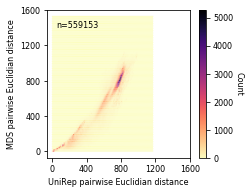

In [81]:
fig = plt.figure(figsize=(3.54, 2.8))
hb = plt.hexbin(rep_dists, mds_dists, 
                cmap='magma_r',
               edgecolors=None)

plt.xticks(np.arange(0, 1800, 400))
plt.yticks(np.arange(0, 1800, 400))
plt.tick_params(labelsize=font_size)

plt.xlabel('UniRep pairwise Euclidian distance', fontsize=font_size)
plt.ylabel('MDS pairwise Euclidian distance', fontsize=font_size)

plt.text(x=50, 
         y=1400, 
         s='n={}'.format(len(rep_dists)), 
         color='black', 
         fontweight='normal',
         fontsize=8)

cb = fig.colorbar(hb)
cb.ax.tick_params(labelsize=font_size)
cb.set_label('Count', rotation=270, 
                     labelpad=10, 
                     fontsize=font_size)

plt.tight_layout()

plt.savefig(join(FIGURES, 'supplemental_mds_euclidian_dist_comparison.png'), dpi=300, facecolor='w', 
        edgecolor='w', orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=1, metadata=None)

plt.savefig(join(FIGURES, 'supplemental_mds_euclidian_dist_comparison.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

#### Setup the colors I want

In [82]:
eukaryota = '#b15928'
bacteria = '#cab2d6'
archaea = '#6a3d9a'
other = '#c8c8c8'


arch_col = '#6a3d9a'
bact_col = '#cab2d6'
euk_col = '#b15928'
other_col = '#cc9933'

cluster0 = '#077084'
cluster1 = '#06a1f7'
cluster2 = '#8214a0'
cluster3 = '#fa78fa'
cluster4 = '#aa0a3c'
cluster5 = '#fa7850'
cluster6 = '#0ab45a'
cluster7 = '#a0fa82'
cluster8 = '#f0f032'
cluster9 = '#fae6be'

colors = (cluster0, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9)

selected = '#069f73'
insoluble = '#5b5b5b'
inactive = '#e79f26'
active = '#069f73'

brenda = 'black'

# set up some plotting parameters
small_point = 3
large_point = 6

font_size = 7

In [83]:
# take a look at pfam domains
display(prop_data[['pfam', 'uid']].groupby('pfam').count())

# save to table
prop_data[['pfam', 'uid']].groupby('pfam').count().reset_index().to_csv(join(FINAL, 'pfam_domain_count.tsv'), sep='\t')

,uid
pfam,
,2
"CL0100,PF01266",2
"CL1350,PF01266",1
"PF00173,PF01070",5
"PF00301,PF01070",2
"PF00929,PF01070",1
PF01070,230
PF01266,379
"PF01266,PF04324",24


In [84]:
prop_data[['superkingdom', 'uid']].groupby('superkingdom').count()

,uid
superkingdom,
Archaea,27
Bacteria,966
Eukaryota,62
hydrocarbon metagenome,1
hydrothermal vent metagenome,2


In [85]:
prop_data[['total_active', 'uid']].groupby('total_active').count()

,uid
total_active,
No,44
Yes,21


In [87]:
def cm2inch(*tupl):
    '''
    https://stackoverflow.com/questions/14708695/specify-figure-size-in-centimeter-in-matplotlib
    '''
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
    
def mm2inch(*tupl):
    '''
    Convert mm to inches.
    '''
    inch = 25.4
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

### Figure 1

PF01070 PF01070 33
PF01070 PF01266 15
PF01070 PF01565 16
PF01070 PF01565PF02913 15
PF01070 PF01266PF04324 15
PF01070 PF02754 13
PF01266 PF01266 55
PF01266 PF01565 16
PF01266 PF01565PF02913 15
PF01266 PF01266PF04324 21
PF01266 PF02754 13
PF01565 PF01565 33
PF01565 PF01565PF02913 20
PF01565 PF01266PF04324 15
PF01565 PF02754 13
PF01565PF02913 PF01565PF02913 35
PF01565PF02913 PF01266PF04324 16
PF01565PF02913 PF02754 12
PF01266PF04324 PF01266PF04324 40
PF01266PF04324 PF02754 12
PF02754 PF02754 49


/home/martin/miniconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


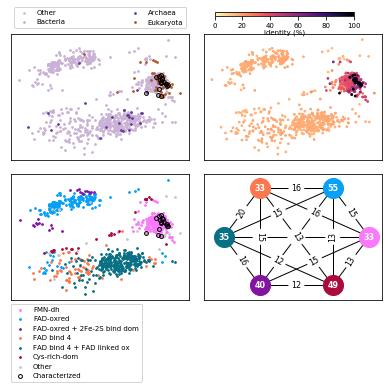

In [104]:


translation = {'PF01070':'FMN-dh', 'PF01266':'FAD-oxred', 'PF01565':'FAD bind 4',
              'PF01565,PF02913':'FAD bind 4 + FAD linked ox', 'PF01266,PF04324':'FAD-oxred + 2Fe-2S bind dom', 
               'PF02754':'Cys-rich-dom', 'other':'Other', 'characterized':'Characterized'
              }



# define colors
dom_color_dict = {'PF01070':cluster3, 
                  'PF01266':cluster1, 
                  'PF01565':cluster5, 
                  'PF01565PF02913':cluster0, 
                  'PF01266PF04324':cluster2, 
                  'PF02754':cluster4,
                  'other':other}


fig = plt.figure(figsize=mm2inch((140, 140)))



#################
## First panel ##
#################

plt.subplot(2, 2, 1)

# Plot of superkingdoms distribution
bac = prop_data.superkingdom == 'Bacteria'
arc = prop_data.superkingdom == 'Archaea'
euk = prop_data.superkingdom == 'Eukaryota'
oth = [not any(s) for s in zip(bac, arc, euk)]
bren = (prop_data.in_brenda == 'Yes') | (prop_data.in_swissprot == 'Yes') # characterized in brenda or wsissprot


plt.scatter(my_plot[:,0][oth], my_plot[:,1][oth], s=small_point, color=other)
plt.scatter(my_plot[:,0][bac], my_plot[:,1][bac], s=small_point, color=bacteria)
plt.scatter(my_plot[:,0][arc], my_plot[:,1][arc], s=small_point, color=archaea)
plt.scatter(my_plot[:,0][euk], my_plot[:,1][euk], s=small_point, color=eukaryota)

# characterized
plt.scatter(my_plot[:,0][bren], my_plot[:,1][bren], s=large_point*2.5,
                linewidths=1,
                facecolor='#00000000', 
                edgecolor='#000000ff')

plt.legend(['Other', 'Bacteria', 'Archaea', 'Eukaryota'], 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)

plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])


##################
## Second panel ##
##################

plt.subplot(2, 2, 2)

sort_mask = np.argsort(prop_data.max_database_sim.values)

sc = plt.scatter(my_plot[:,0][sort_mask], my_plot[:,1][sort_mask], 
                 s=small_point, 
                 c=prop_data.max_database_sim.values[sort_mask], 
                 cmap='magma_r', # low contrast: 'viridis' 'plasma' high contrast: 'inferno' 'magma'
                 vmin=0,
                 vmax=100)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])
plt.tick_params(labelsize=font_size)

cbaxes = fig.add_axes([0.55, 0.95, 0.35, 0.01]) #[left, bottom, width, height]
cb = fig.colorbar(sc, orientation="horizontal", cax=cbaxes)
cb.ax.tick_params(labelsize=font_size) 
cb.set_label('Identity (%)', 
                     rotation=0, 
                     labelpad=0, 
                     fontsize=font_size) 





#################
## Third panel ##
#################

plt.subplot(2, 2, 3)

PF01070 = prop_data.pfam.values == 'PF01070' # PF01070, FMN dehydrogenase
PF01266 = prop_data.pfam.values == 'PF01266' # PF01266, FAD dependent oxidoreductase family
PF01565 = prop_data.pfam.values == 'PF01565' # PF01565, FAD_binding_4
PF01565PF02913 = prop_data.pfam.values == 'PF01565,PF02913' # FAD_binding_4 AND FAD linked oxidases, C-terminal domain
PF01266PF04324 = prop_data.pfam.values == 'PF01266,PF04324' # FAD dependent oxidoreductase family AND BFD-like [2Fe-2S] binding domain
PF02754 = prop_data.pfam.values == 'PF02754' # PF02754, Cys-rich-dom
background = [not any(s) for s in zip(PF01266, PF01070, PF02754, PF01565, PF01565PF02913, PF01266PF04324)]
bren = (prop_data.in_brenda == 'Yes') | (prop_data.in_swissprot == 'Yes') # characterized in brenda or swissprot


plt.scatter(my_plot[:,0][PF01070], my_plot[:,1][PF01070], 
            s=small_point, 
            color=dom_color_dict['PF01070'])

plt.scatter(my_plot[:,0][PF01266], my_plot[:,1][PF01266], 
            s=small_point, 
            color=dom_color_dict['PF01266'])

plt.scatter(my_plot[:,0][PF01266PF04324], my_plot[:,1][PF01266PF04324], 
            s=small_point, 
            color=dom_color_dict['PF01266PF04324'])

plt.scatter(my_plot[:,0][PF01565], my_plot[:,1][PF01565], 
            s=small_point, 
            color=dom_color_dict['PF01565'])

plt.scatter(my_plot[:,0][PF01565PF02913], my_plot[:,1][PF01565PF02913], 
            s=small_point, 
            color=dom_color_dict['PF01565PF02913'])

plt.scatter(my_plot[:,0][PF02754], my_plot[:,1][PF02754], 
            s=small_point, 
            color=dom_color_dict['PF02754'])

plt.scatter(my_plot[:,0][background], my_plot[:,1][background], 
            s=small_point, 
            color=dom_color_dict['other'])

#characterized
plt.scatter(my_plot[:,0][bren], my_plot[:,1][bren], s=large_point*2.5,
                linewidths=1,
                facecolor='#00000000', 
                edgecolor='#000000ff')

plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.legend([translation['PF01070'], translation['PF01266'], translation['PF01266,PF04324'],
            translation['PF01565'], translation['PF01565,PF02913'],  translation['PF02754'], 
            translation['other'], translation['characterized']], 
           fontsize=font_size,
           loc='upper left',
           bbox_to_anchor=(-0.02, 0),
           #mode = 'expand',
           ncol=1)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])



##################
## Fourth panel ##
##################

ax = plt.subplot(2, 2, 4)

# check average identity between the sequences with different domains

# define a list of domains
dom_subsets_names = ['PF01070', 'PF01266', 'PF01565', 'PF01565PF02913', 'PF01266PF04324', 'PF02754']
dom_subsets = [PF01070, PF01266, PF01565, PF01565PF02913, PF01266PF04324, PF02754]



# iterate through each pair of domains and compute the mean
node_data = []
edge_data = []
for i in range(len(dom_subsets)):
    for j in range(len(dom_subsets)):
        
        if i > j:
            continue
            
        id_list_i = prop_data[dom_subsets[i]].uid.tolist()
        id_list_j = prop_data[dom_subsets[j]].uid.tolist()

        # subset the identity matrix
        data_matrix = df_ident.loc[id_list_i, id_list_j]
            
        if i == j: # save to node data structure
            node_data.append((dom_subsets_names[i], int(round(data_matrix.mean().mean()))))

        else: # save to edge data structure
            edge_data.append((dom_subsets_names[i], dom_subsets_names[j], int(round(data_matrix.mean().mean()))))

        print(dom_subsets_names[i], dom_subsets_names[j], int(round(data_matrix.mean().mean())))
        
        
        

# now create a graph
G = nx.Graph()

# add nodes
G.add_nodes_from(dom_subsets_names)

for d in edge_data:
    G.add_edge(d[0], d[1], weight=d[2])

# do the network layout
pos = nx.circular_layout(G) 

# draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=1)

# add weight labels to the edges
labels = nx.get_edge_attributes(G, 'weight')
_ = nx.draw_networkx_edge_labels(G, pos, 
                                 edge_labels=labels,
                                 font_size=8)

# draw nodes
for node in dom_subsets_names:
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[node],
                           node_color=dom_color_dict[node],
                           node_size=400,
                           alpha=1)
    
# add identity within cluster onto the nodes
labels={k:v for k,v in node_data}
nx.draw_networkx_labels(G, pos, 
                        labels, 
                        font_size=8,
                        font_color='w',
                        font_weight='bold')


plt.tight_layout()

plt.savefig(join(FIGURES, 'figure1.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig(join(FIGURES, 'figure1.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

## Figure 2 and 3

In [105]:
import abc_tools
import vislib

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage


In [106]:
def filter_matrix_for_ids(data_matrix, id_list):
    '''
    Subset a pairwise identity matrix to retain only the desired identifiers.
    '''
    # make sure all the identifiers are present in the identity matrix
    for uid in id_list:
        assert uid in data_matrix.index, 'Error, %s not present in identity matrix' % uid

    for uid in id_list:
        assert uid in data_matrix.index, 'Error, %s not present in identity matrix' % uid


    # make a subset of the identity matrix
    return data_matrix.loc[id_list, id_list]


def den_from_id_matrix(data_matrix, linkage_type='average'):
    '''
    Build a dendrogram from the pre-computed pairwise protein idnetities.
    '''

    # convert the similarity matrix to a distance matrix
    data_dist_matrix = data_matrix.apply(lambda value: 100-value)

    # cut the matrix in half (condensed distance matrix)
    dists = squareform(data_dist_matrix.values)

    # make a linkage matrix
    linkage_matrix = linkage(dists, linkage_type)

    # make dendrogram object
    den = dendrogram(linkage_matrix, labels=data_dist_matrix.index)

    #plt.show()

    return den


# get the dendrogram plotting data coordinates
def extract_plotting_coordinates(den):
    '''
    Get the x, y coordinates for ach index.
    '''
    x_coordinates = den['icoord']
    y_coordinates = den['dcoord']
    index = den['ivl']
    coordinate_data = []
    label_data = {}
    i = 0
    # the dendrogram is drawn as "half boxes" with each point described by a list of four x and four y coordinates
    # extract these for later plotting
    for x_list, y_list in zip(x_coordinates, y_coordinates):
        xy_pairs = zip(x_list, y_list)
        # also want to get the end nodes, where the labels are supposed to go
        pairs = []
        for x, y in xy_pairs:
            pair = (x, y)
            pairs.append(pair)
            # if y is zero, then that is a place where the label should go
            if y == 0.0:
                label_data[index[i]] = pair
                i += 1
        coordinate_data.append(pairs)
    return coordinate_data, label_data


def load_and_normalize_data_new(filepath, xfold_cutoff=5):
    '''
    Use new normalization that keeps information of relative rates.
    '''
    data = pd.read_csv(filepath, index_col = 'protein', sep='\t')

    # rename protein column
    data.index.name = 'uid'

    # subtract the blank from the other activities
    ratio_df = data.sub(data.blank, axis=0)

    # average the three measurements
    by_protein = ratio_df.groupby(by = 'uid')
    meandf = by_protein.mean()
    stdevdf = by_protein.std()

    # take mean of BSA control and add two standard deviations
    meandf.loc['BSA_stdev'] = stdevdf.loc['BSA_control']
    meandf.loc['BSA_mean'] =  meandf.loc['BSA_control']

    # subtract the LOD and only keep what's larger
    hit_df = meandf - meandf.loc['BSA_mean']
    hit_df = hit_df[hit_df > xfold_cutoff*meandf.loc['BSA_stdev']]

    # drop unneeded columns
    hit_df = hit_df.drop(['BSA_control', 'no_protein', 'BSA_stdev', 'BSA_mean'], axis=0)
    hit_df = hit_df.drop(['blank'], axis = 1)

    # drop lines with only nan and replace nan with 0
    hit_df.dropna(how='all', axis=0, inplace=True)
    hit_df = hit_df.replace(np.nan, 0, regex=True)

    # for each enzyme normalize to the highest value
    hit_df_norm = hit_df.div(hit_df.max(axis=1), axis=0)
    
    return hit_df_norm




#### Load batch 1 experiment data

In [107]:
# set a cutoff for how many times the activity should be of the mean
xfold_cutoff = 4


# load up the data from both batches
filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep0.tsv')
data1 = load_and_normalize_data_new(filepath, xfold_cutoff)

filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep1_data.tsv')
data2 = load_and_normalize_data_new(filepath, xfold_cutoff)

filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep3.tsv')
data3 = load_and_normalize_data_new(filepath, xfold_cutoff)
    
# combine data and count occurances of each identifier
all_uid = list(data1.index) + list(data2.index) + list(data3.index)
item_count = Counter(all_uid)
recurring_uids = sorted(list(set([s for s in all_uid if item_count[s] > 1])))

# merge the results and take the mean
all_data = pd.concat([data1, data2, data3])

# keep only the ones that are present at least twice
all_data = all_data.loc[recurring_uids]

# average the measurements
by_protein = all_data.groupby(by = 'uid')
first_batch = by_protein.mean()

# add uid column
first_batch['uid'] = first_batch.index
first_batch.reset_index(drop=True, inplace=True)

display(first_batch)

,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,uid
0,0.015699,0.017282,1.000000,0.785280,0.002713,0.031748,A0A087D1R1
1,0.000000,0.088789,1.000000,0.459008,0.000000,0.020576,A0A0M7LBC1
2,0.000000,0.404241,0.419254,0.273128,0.000000,0.587685,A4YVE0
3,0.259470,0.992531,0.004065,0.698796,0.094554,0.005946,A9QH69
4,0.007704,0.107342,0.108568,1.000000,0.149599,0.622852,B1HZY7
5,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,B7N6P4
6,0.500000,0.500000,0.000000,0.000000,0.124377,0.000000,B7RR92
7,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,C0XIJ3
8,0.108817,1.000000,0.004359,0.748979,0.105744,0.071645,C4VMW0
9,0.350992,0.874893,0.402756,0.916395,0.256889,0.910859,C9Y9E7


#### Load batch 2 experiment data

In [108]:
# load up the data from both batches
filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep1.tsv')
data1 = load_and_normalize_data_new(filepath, xfold_cutoff)

filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep2.tsv')
data2 = load_and_normalize_data_new(filepath, xfold_cutoff)

filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep3.tsv')
data3 = load_and_normalize_data_new(filepath, xfold_cutoff)
    
# combine data and count occurances of each identifier
all_uid = list(data1.index) + list(data2.index) + list(data3.index)
item_count = Counter(all_uid)
recurring_uids = sorted(list(set([s for s in all_uid if item_count[s] > 1])))

# merge the results and take the mean
all_data = pd.concat([data1, data2, data3])

# keep only the ones that are present at least twice
all_data = all_data.loc[recurring_uids]

# average the measurements
by_protein = all_data.groupby(by = 'uid')
second_batch = by_protein.mean()

# add uid column
second_batch['uid'] = second_batch.index
second_batch.reset_index(drop=True, inplace=True)

display(second_batch)


,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,uid
0,0.056187,0.000000,1.000000,0.000000,0.0,0.000000,A0A011QK89
1,0.000000,0.057039,1.000000,0.000000,0.0,0.000000,A0A077SBA9
2,0.500000,0.500000,0.000000,0.000000,0.0,0.000000,A0A0B2PSV8
3,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,A0A0U6K8E5
4,0.937885,0.915310,0.429175,0.731178,0.0,0.098491,B8MKR3
5,0.012984,1.000000,0.000000,0.180232,0.0,0.011268,C2K1F0
6,0.027441,0.933563,0.000000,0.914660,0.0,0.998205,E6SCX5
7,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,R0EVG9
8,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,S2DJ52


#### Combine the two batches and add to property data

In [109]:
both_batches = pd.concat([first_batch, second_batch])
both_batches = both_batches.reset_index(drop=True)

display(both_batches)
display(both_batches.describe())

# # merge with other data 
# uid_data = uid_data.merge(both_batches, on='uid', how='left')

# display(uid_data.head())
# display(uid_data.tail())
# display(uid_data.describe())

,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,uid
0,0.015699,0.017282,1.000000,0.785280,0.002713,0.031748,A0A087D1R1
1,0.000000,0.088789,1.000000,0.459008,0.000000,0.020576,A0A0M7LBC1
2,0.000000,0.404241,0.419254,0.273128,0.000000,0.587685,A4YVE0
3,0.259470,0.992531,0.004065,0.698796,0.094554,0.005946,A9QH69
4,0.007704,0.107342,0.108568,1.000000,0.149599,0.622852,B1HZY7
5,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,B7N6P4
6,0.500000,0.500000,0.000000,0.000000,0.124377,0.000000,B7RR92
7,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,C0XIJ3
8,0.108817,1.000000,0.004359,0.748979,0.105744,0.071645,C4VMW0
9,0.350992,0.874893,0.402756,0.916395,0.256889,0.910859,C9Y9E7


,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.119728,0.474625,0.390341,0.346468,0.046574,0.204270
std,0.233163,0.429348,0.460492,0.400159,0.097196,0.348127
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.012962,0.000000,0.000000,0.000000,0.000000
50%,0.007249,0.500000,0.056464,0.090116,0.000000,0.002973
75%,0.094329,0.948305,1.000000,0.735628,0.025673,0.220789
max,0.937885,1.000000,1.000000,1.000000,0.381268,0.998205


### Figure 2a

,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam,max_database_sim,max_active_sim,max_all_sim
70,C0XIJ3,1423757.0,Lactobacillus hilgardii,Bacteria,6.35,33.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_3,PF01070,57.0,47.3,57.0
151,Q15TJ7,342610.0,Pseudoalteromonas atlantica,Bacteria,7.60,22.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_3,PF01070,38.4,40.2,40.2
154,B8MMC0,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_3,"PF00173,PF01070",27.2,40.2,40.2
212,A4YVE0,114615.0,Bradyrhizobium sp.,Bacteria,7.00,27.0,1.1.3.15,Yes,Yes,Yes,...,Yes,No,Yes,No,No,cluster_3,PF01070,34.4,100.0,100.0
293,B8MKR3,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,1.1.3.15,Yes,Yes,Yes,...,Yes,No,Yes,No,No,cluster_3,"PF00173,PF01070",28.6,100.0,100.0


(24, 24)

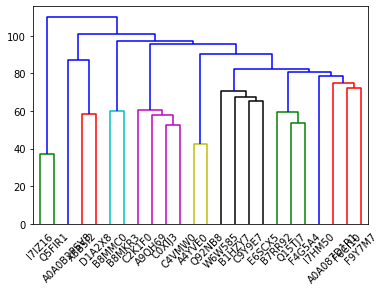

In [172]:
import imp
imp.reload(vislib)

# select all soluble sequences
df_subset = prop_data[(prop_data['total_soluble']=='Yes') & (prop_data['pfam'].str.contains('PF01070'))]
display(df_subset.head())

soluble_ids = df_subset.uid.values

# filter the identity matrix to contain only these
data_matrix = filter_matrix_for_ids(data_matrix=df_ident, id_list=soluble_ids)
display(data_matrix.shape)


# make dendrogram
den = den_from_id_matrix(data_matrix, linkage_type='ward')

# get info from the dendrogam
coordinate_data, label_data = extract_plotting_coordinates(den)

# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), sep=';', index_col=0)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), sep=';', index_col=0)
substrate_data = data1.append(data2)

# keep only soluble ones
substrate_data = substrate_data.loc[soluble_ids]

# set all values to zero
substrate_data = substrate_data.replace(True, 0)

# convert to a dictionary
substrate_data_dict = substrate_data.to_dict('index')

# now combined with the quantitative data loaded before
both_batches_dict = both_batches.set_index('uid').to_dict('index')

# both_batches only have data for some of the sequences, need to add zeros for soluble but non-active ones
for uid in sorted(substrate_data_dict.keys()):
    if both_batches_dict.get(uid) is None:
        both_batches_dict[uid] = substrate_data_dict[uid]

# assign substrate colors
cmap = matplotlib.cm.get_cmap('binary')

for uid in sorted(both_batches_dict.keys()):
    for substrate in both_batches_dict[uid].keys():
        
        rgba = cmap(both_batches_dict[uid][substrate])
        color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
        both_batches_dict[uid][substrate] = color
        
# get colors for the legend
legend_cols = []
for v in np.arange(0, 1.01, 0.01):
    rgba = cmap(v)
    color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
    legend_cols.append(color)
    
        
# get a dictionary with properties that I want to color
property_frame = df_subset[['uid', 'superkingdom']].set_index('uid')
property_dict = property_frame.to_dict('index')

# assign property colors
property_colors = {'superkingdom':{'Archaea':archaea,'Bacteria':bacteria, 'Eukaryota':eukaryota, 'Other':other}}


# make the plot
vislib.substrate(data=label_data, 
                 dend_data=coordinate_data, 
                 subst_data=both_batches_dict, 
                 subst_data_replicate=both_batches_dict, 
                 property_dict=property_dict, 
                 property_colors=property_colors,
                 legend_colors=legend_cols,
                 filepath=join(FIGURES, 'figure2a_{}x.svg'.format(xfold_cutoff)), 
                 main='1.1.3.15',
                 substrate_order=['glycolate', 'lactate', '2-hydroxyoctanoate', 
                                  'mandelate', '2-hydroxystearate', '2-hydroxyglutarate'])

### Figure 3a

,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam,max_database_sim,max_active_sim,max_all_sim
87,A0A0J6V898,1800.0,Mycolicibacterium chubuense,Bacteria,NaN,NaN,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_0,"PF01266,PF04324",17.6,22.5,22.5
161,A0A0H2LZ12,34073.0,Variovorax paradoxus,Bacteria,6.91,28.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_0,PF01266,18.2,22.0,22.0
241,A0A0M7LBC1,134375.0,Achromobacter sp.,Bacteria,7.10,28.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_0,PF01266,17.8,55.0,55.0
273,A0A0J1FVG5,476652.0,Desulfosporosinus acididurans,Bacteria,NaN,30.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_0,PF01266,18.2,40.0,40.0
358,A0A021XIZ9,1410620.0,Shinella sp.,Bacteria,7.22,30.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_0,PF01266,17.3,50.8,50.8


(17, 17)

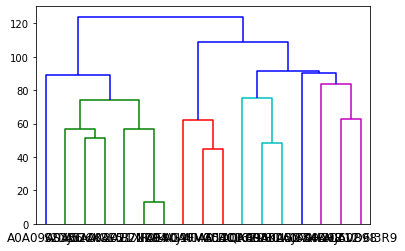

In [168]:

# select all soluble sequences
df_subset = prop_data[(prop_data['total_soluble']=='Yes') & 
                      (prop_data['pfam'].str.contains('PF01266'))]
display(df_subset.head())

soluble_ids = df_subset.uid.values

# filter the identity matrix to contain only these
data_matrix = filter_matrix_for_ids(data_matrix=df_ident, id_list=soluble_ids)
display(data_matrix.shape)


# make dendrogram
den = den_from_id_matrix(data_matrix, linkage_type='ward')

# get info from the dendrogam
coordinate_data, label_data = extract_plotting_coordinates(den)

# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), sep=';', index_col=0)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), sep=';', index_col=0)
substrate_data = data1.append(data2)

# keep only soluble ones
substrate_data = substrate_data.loc[soluble_ids]

# set all values to zero
substrate_data = substrate_data.replace(True, 0)

# convert to a dictionary
substrate_data_dict = substrate_data.to_dict('index')

# now combined with the quantitative data loaded before
both_batches_dict = both_batches.set_index('uid').to_dict('index')

# both_batches only have data for some of the sequences, need to add zeros for soluble but non-active ones
for uid in sorted(substrate_data_dict.keys()):
    if both_batches_dict.get(uid) is None:
        both_batches_dict[uid] = substrate_data_dict[uid]

# assign substrate colors
cmap = matplotlib.cm.get_cmap('binary')

for uid in sorted(both_batches_dict.keys()):
    for substrate in both_batches_dict[uid].keys():
        
        rgba = cmap(both_batches_dict[uid][substrate])
        color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
        both_batches_dict[uid][substrate] = color

# get colors for the legend
legend_cols = []
for v in np.arange(0, 1.01, 0.01):
    rgba = cmap(v)
    color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
    legend_cols.append(color)
        
# get a dictionary with properties that I want to color
property_frame = df_subset[['uid', 'superkingdom']].set_index('uid')
property_dict = property_frame.to_dict('index')

# assign property colors
property_colors = {'superkingdom':{'Archaea':archaea,'Bacteria':bacteria, 'Eukaryota':eukaryota, 'Other':other}}


# make the plot
vislib.substrate(data=label_data, 
                 dend_data=coordinate_data, 
                 subst_data=both_batches_dict, 
                 subst_data_replicate=both_batches_dict, 
                 property_dict=property_dict, 
                 property_colors=property_colors, 
                 legend_colors=legend_cols,
                 filepath=join(FIGURES, 'figure3a_{}x.svg'.format(xfold_cutoff)), 
                 main='1.1.3.15',
                 substrate_order=['glycolate', 'lactate', '2-hydroxyoctanoate', 
                                  'mandelate', '2-hydroxystearate', '2-hydroxyglutarate'])

### Figure 3b

,uid,taxid,organism,superkingdom,ph,temperature,ec,synthesized,substrate_available,total_soluble,...,2-hydroxyoctanoate,2-hydroxystearate,mandelate,in_brenda,in_swissprot,cluster,pfam,max_database_sim,max_active_sim,max_all_sim
47,A0A073CBY9,388467.0,Planktothrix agardhii,Bacteria,NaN,21.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_1,PF01565,16.6,21.8,21.8
225,A0A0P7Z009,1666908.0,Erythrobacteraceae bacterium,Bacteria,NaN,NaN,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_1,"PF01565,PF02913",15.9,21.3,21.3
243,K4LGZ0,1089553.0,Thermacetogenium phaeum,Bacteria,7.05,55.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_1,"PF01565,PF02913",18.9,21.7,21.7
310,W6I5R7,364410.0,Granulibacter bethesdensis,Bacteria,NaN,36.0,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_1,PF01565,17.7,20.5,20.5
328,S6BUT8,1248727.0,Endosymbiont of,Bacteria,NaN,NaN,1.1.3.15,Yes,Yes,Yes,...,No,No,No,No,No,cluster_5,PF02754,18.1,17.0,18.1


(24, 24)

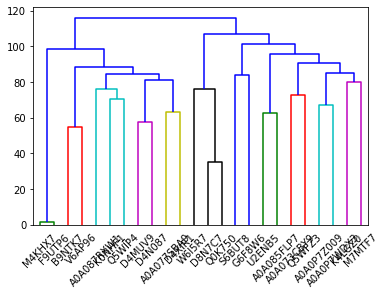

In [169]:

# select all soluble sequences
df_subset = prop_data[(prop_data['total_soluble']=='Yes') & 
                      (prop_data['pfam'].str.contains('PF01070')==False) &
                      (prop_data['pfam'].str.contains('PF01266')==False)]
display(df_subset.head())

soluble_ids = df_subset.uid.values

# filter the identity matrix to contain only these
data_matrix = filter_matrix_for_ids(data_matrix=df_ident, id_list=soluble_ids)
display(data_matrix.shape)


# make dendrogram
den = den_from_id_matrix(data_matrix, linkage_type='ward')

# get info from the dendrogam
coordinate_data, label_data = extract_plotting_coordinates(den)

# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), sep=';', index_col=0)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), sep=';', index_col=0)
substrate_data = data1.append(data2)

# keep only soluble ones
substrate_data = substrate_data.loc[soluble_ids]

# set all values to zero
substrate_data = substrate_data.replace(True, 0)

# convert to a dictionary
substrate_data_dict = substrate_data.to_dict('index')

# now combined with the quantitative data loaded before
both_batches_dict = both_batches.set_index('uid').to_dict('index')

# both_batches only have data for some of the sequences, need to add zeros for soluble but non-active ones
for uid in sorted(substrate_data_dict.keys()):
    if both_batches_dict.get(uid) is None:
        both_batches_dict[uid] = substrate_data_dict[uid]

# assign substrate colors
cmap = matplotlib.cm.get_cmap('binary')

for uid in sorted(both_batches_dict.keys()):
    for substrate in both_batches_dict[uid].keys():
        
        rgba = cmap(both_batches_dict[uid][substrate])
        color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
        both_batches_dict[uid][substrate] = color
        
# get colors for the legend
legend_cols = []
for v in np.arange(0, 1.01, 0.01):
    rgba = cmap(v)
    color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
    legend_cols.append(color)
        
# get a dictionary with properties that I want to color
property_frame = df_subset[['uid', 'superkingdom']].set_index('uid')
property_dict = property_frame.to_dict('index')

# assign property colors
property_colors = {'superkingdom':{'Archaea':archaea,'Bacteria':bacteria, 'Eukaryota':eukaryota, 'Other':other}}


# make the plot
vislib.substrate(data=label_data, 
                 dend_data=coordinate_data, 
                 subst_data=both_batches_dict, 
                 subst_data_replicate=both_batches_dict, 
                 property_dict=property_dict, 
                 property_colors=property_colors, 
                 legend_colors=legend_cols,
                 filepath=join(FIGURES, 'figure3b_{}x.svg'.format(xfold_cutoff)), 
                 main='1.1.3.15',
                 substrate_order=['glycolate', 'lactate', '2-hydroxyoctanoate', 
                                  'mandelate', '2-hydroxystearate', '2-hydroxyglutarate'])

## Figure 3c

In [187]:
def remove_redundant_from_pfam(pfam, unirep):
    '''
    Takes a pfam dataframe and one containing unirep embeddings.
    Uses the embeddings to filter out redundant entries.
    '''
    # make sure the unirep df has the same identifiers as the pfam df
    unirep = unirep[unirep['uid'].isin(pfam['uid'].values)].reset_index(drop=True)

    # find duplicated items
    dups = unirep.drop('uid', axis=1).duplicated()

    # get the identifiers of duplicates
    dup_ids = unirep[dups].uid.values

    # remove duplicates
    unirep_nodups = unirep.drop('uid', axis=1).drop_duplicates()

    # get the index of remaining and make subset
    unirep = unirep.loc[unirep_nodups.index.values]
    pfam = pfam[pfam.uid.isin(unirep.uid.values)]
    
    return pfam



## 2017 ##
# load up the 2017 pfam data
filepath = join(FINAL, 'brenda_2017_1', 'pfam_info_2017_1.tsv')
pfam_df_2017 = pd.read_csv(filepath, sep='\t')

# load up the 2017 unirep embeddings
unirep_2017 = load_unirep(uni_filepath=join(INTERMEDIATE, 'brenda_2017_1', '1_1_3__BRENDA_sequences_filtered_2017_1_unirep.csv'),
                       prop_filepath=join(FINAL, 'brenda_2017_1', 'ec_uid_org_from_fasta_2017_1.tsv'),
                       ec='1.1.3.15')

# count the number of each of the domains in 2017
result = pd.DataFrame(pfam_df_2017.drop('uid', axis=1)['pfam'].value_counts())

my_doms = result.loc[['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324']]
my_doms.columns = ['2017']

other_doms = pd.DataFrame(result.drop(['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324'], axis=0).sum())
other_doms.columns = ['2017']
other_doms.index = ['other']

sums_2017 = my_doms.append(other_doms)




## 2019 ##
# load up the 2019 pfam data
filepath = join(FINAL, 'brenda_2019_2', 'pfam_info_2019_2.tsv')
pfam_df_2019 = pd.read_csv(filepath, sep='\t')

# load up the 2019 unirep embeddings
unirep_2019 = load_unirep(uni_filepath=join(INTERMEDIATE, 'brenda_2019_2', '1_1_3__BRENDA_sequences_filtered_2019_2_unirep.tsv'),
                       prop_filepath=join(FINAL, 'brenda_2019_2', 'ec_uid_org_from_fasta_2019_2.tsv'),
                       ec='1.1.3.15', sep='\t')

# find which ones are redundant and remove
pfam_df_2019 = remove_redundant_from_pfam(pfam_df_2019, unirep_2019)

# count the number of each of the domains in 2019
result = pd.DataFrame(pfam_df_2019.drop('uid', axis=1)['pfam'].value_counts())

my_doms = result.loc[['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324']]
my_doms.columns = ['2019']

other_doms = pd.DataFrame(result.drop(['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324'], axis=0).sum())
other_doms.columns = ['2019']
other_doms.index = ['other']

sums_2019 = my_doms.append(other_doms)


# join the two data frames
domain_stats = sums_2017.join(sums_2019)
display(domain_stats)

# get the domain order
pfam_dom_order = domain_stats.index

# rename the index to human-readable
domain_stats.index = [translation[s] for s in domain_stats.index]
display(domain_stats)

,2017,2019
PF01266,661,650
PF01070,240,219
PF02754,81,34
PF01565,70,78
"PF01565,PF02913",312,350
"PF01266,PF04324",24,220
other,21,108


,2017,2019
FAD-oxred,661,650
FMN-dh,240,219
Cys-rich-dom,81,34
FAD bind 4,70,78
FAD bind 4 + FAD linked ox,312,350
FAD-oxred + 2Fe-2S bind dom,24,220
Other,21,108


In [188]:
pfam_df_2017.shape

(1411, 2)

In [189]:
pfam_df_2019.shape

(1659, 2)

In [190]:
# check what proportion of sequences has each of the domains
domain_stats.div(domain_stats.sum().values) * 100


,2017,2019
FAD-oxred,46.912704,39.180229
FMN-dh,17.033357,13.200723
Cys-rich-dom,5.748758,2.049427
FAD bind 4,4.968062,4.701627
FAD bind 4 + FAD linked ox,22.143364,21.097046
FAD-oxred + 2Fe-2S bind dom,1.703336,13.261001
Other,1.490419,6.509946


In [191]:
# want to see what's in that "other" category in 2019
result.drop(['PF01266', 'PF01070', 'PF02754', 'PF01565', 'PF01565,PF02913', 'PF01266,PF04324'], axis=0)

,pfam
"PF02754,PF12838",52
"PF02754,PF13183",31
"PF00173,PF01070",4
PF02913,3
"PF00301,PF01070",2
"CL3434,PF01565,PF02913",1
"PF01266,PF39027",1
"PF01266,PF01932",1
"PF01266,PF04324,PF04972",1
"CL7431,PF01266",1


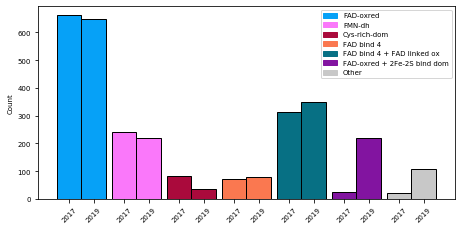

In [192]:
# get appropriate colors
dom_cols = [dom_color_dict[s.replace(',', '')] for s in pfam_dom_order]

# now plot
N = len(domain_stats.index)
ind = np.arange(N)    # the x locations for the groups
width = 0.9       # the width of the bars: can also be len(x) sequence


plt.figure(figsize=(cm2inch(19, 9)))

ax = plt.subplot(111)

ax.bar(2*ind-0.45, domain_stats['2017'], 
            width, 
            color=dom_cols,
            edgecolor='black',
            align='center')

ax.bar(2*ind+0.45, domain_stats['2019'], 
             width, 
            color=dom_cols,
            edgecolor='black',
            align='center')


# tweak the axis
list1 = ['2017']*len(ind)
list2 = ['2019']*len(ind)
labels = [None]*(len(list1)+len(list2))
labels[::2] = list1
labels[1::2] = list2

list1 = 2*ind-0.45
list2 = 2*ind+0.45
inds = [None]*(len(list1)+len(list2))
inds[::2] = list1
inds[1::2] = list2

plt.xticks(inds, labels, rotation=45)


# add a legend for the colors
my_handles = [Patch(color=dom_cols[i], label=domain_stats.index[i]) for i in range(N)]
plt.legend(handles=my_handles,
         fontsize=font_size)

# labels
plt.xlabel(None)
plt.ylabel('Count', fontsize=font_size)
plt.tick_params(labelsize=font_size)


plt.savefig(join(FIGURES, 'figure3c.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig(join(FIGURES, 'figure3c.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

## Figure 4

In [173]:


import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator




IndexError: index 2 is out of bounds for axis 0 with size 2

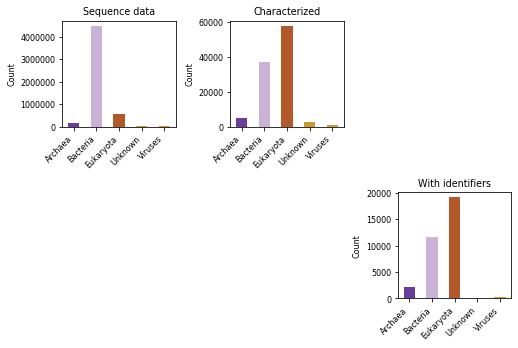

In [197]:
# define font size
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

    
filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs_domain_2.tsv')
df_html_uid = pd.read_csv(filepath, sep='\t')

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs_domain_2.tsv')
df_html = pd.read_csv(filepath, sep='\t')

df_html_combined = df_html_uid.drop('uid', axis=1).append(df_html) # combine to one frame

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2_kdist_aln.tsv')
df_fasta = pd.read_csv(filepath, sep='\t')


arch_col = '#6a3d9a'
bact_col = '#cab2d6'
euk_col = '#b15928'
other_col = '#cc9933'


ncols = 3
nrows = 3



fig1 = plt.figure(figsize=cm2inch(18, 18), constrained_layout=True)
gs = fig1.add_gridspec(nrows, ncols)


################
## First plot ##
################
f1_ax1 = fig1.add_subplot(gs[0, 0:1])

df_fasta.groupby('domain').count()['ec'].plot(kind='bar', 
                                                 color=[arch_col, bact_col, euk_col, 
                                                        other_col, other_col])
plt.title('Sequence data')
plt.ylabel('Count')
plt.xlabel(None)
plt.xticks(rotation=45, ha='right')

#################
## Second plot ##
#################
f1_ax2 = fig1.add_subplot(gs[0, 1:2])

df_html_combined.groupby('domain').count()['ec'].plot(kind='bar', 
                                                 color=[arch_col, bact_col, euk_col, 
                                                        other_col, other_col])
plt.title('Characterized')
plt.ylabel('Count')
plt.xlabel(None)
plt.xticks(rotation=45, ha='right')


# ################
# ## Third plot ##
# ################
# f1_ax3 = fig1.add_subplot(gs[0, 2:3])

# plt.hist(df_html_combined.groupby('ec').count()['organism'].reset_index()['organism'], 
#          bins=50, 
#          range=(0, 50),
#          color='black')
# plt.title('Characterized')
# plt.xlabel('Enzymes per EC')
# plt.ylabel('Frequency')


# #################
# ## Fourth plot ##
# #################
# f1_ax4 = fig1.add_subplot(gs[1, 0:2])

# top_orgs = df_html_combined.groupby('organism').nunique()['ec'].nlargest(12)

# labels = list(top_orgs.index)
# labels.reverse()

# # asign colors
# colors = []
# for l in labels:
#     dom = df_html[df_html['organism']==l].domain.unique()[0]
#     if dom == 'Eukaryota':
#         colors.append(euk_col)
        
#     elif dom == 'Archaea':
#         colors.append(arch_col)
        
#     elif dom == 'Bacteria':
#         colors.append(bact_col)
        
#     else:
#         colors.append(other_col)
        

# labels = ['%s. %s' % (s[0], s.split()[1]) for s in labels] # shorten organism name

# values = list(top_orgs.values)
# values.reverse()



# # plot the lines
# for i, org in enumerate(labels):
#     plt.hlines(y=org, xmin=0, xmax=values[i], color='#ababab')
#     plt.plot(values[i], org, "o", color=colors[i])


# # Add titles and axis names
# plt.yticks(labels, fontstyle='italic')
# plt.xlabel('Unique EC numbers characterized (#)')

# plt.xticks(np.arange(0, 1500, step=250))
# f1_ax4.xaxis.set_major_locator(MaxNLocator(integer=True))


################
## Fifth plot ##
################
f1_ax5 = fig1.add_subplot(gs[1, 2:3])

df_html_uid.groupby('domain').count()['ec'].plot(kind='bar', 
                                                 color=[arch_col, bact_col, euk_col, 
                                                        other_col, other_col])
plt.title('With identifiers')
plt.xlabel(None)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')

################
## Sixth plot ##
################
f1_ax6 = fig1.add_subplot(gs[2, 0:1])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax6.axvline(x=25, color='black', ls='--')

plt.hist(df_fasta[df_fasta['domain'] == 'Archaea'].identity, 
         bins=100, 
         range=(0, 100),
         color=arch_col)
plt.xlabel('Identity with characterized')
plt.ylabel('Frequency')
plt.title('Archaea')


##################
## Seventh plot ##
##################
f1_ax7 = fig1.add_subplot(gs[2, 1:2])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax7.axvline(x=25, color='black', ls='--')

plt.hist(df_fasta[df_fasta['domain'] == 'Bacteria'].identity, 
         bins=100, 
         range=(0, 100),
         color=bact_col)
plt.xlabel('Identity with characterized')
plt.ylabel('Frequency')
plt.title('Bacteria')

#################
## Eighth plot ##
#################
f1_ax8 = fig1.add_subplot(gs[2, 2:3])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax8.axvline(x=25, color='black', ls='--')

plt.hist(df_fasta[df_fasta['domain'] == 'Eukaryota'].identity, 
         bins=100, 
         range=(0, 100),
         color=euk_col)

#rect = matplotlib.patches.Rectangle((0, 0), width=30, height=f1_ax8.get_ylim()[1], fill='#cdcbc9')
#f1_ax8.add_patch(rect)
plt.xlabel('Identity with characterized')
plt.ylabel('Frequency')
plt.title('Eukaryota')


plt.savefig(join(FIGURES, 'figure4.png'), dpi=300, 
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


plt.savefig(join(FIGURES, 'figure4.pdf'),
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

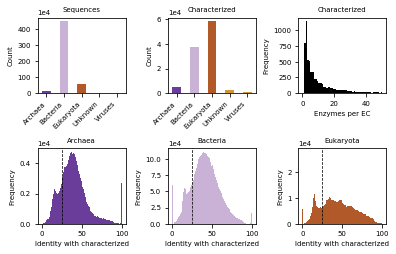

In [221]:
# define font size
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

    
filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs_domain_2.tsv')
df_html_uid = pd.read_csv(filepath, sep='\t')

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_all_orgs_domain_2.tsv')
df_html = pd.read_csv(filepath, sep='\t')

df_html_combined = df_html_uid.drop('uid', axis=1).append(df_html) # combine to one frame

filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2_kdist_aln.tsv')
df_fasta = pd.read_csv(filepath, sep='\t')


arch_col = '#6a3d9a'
bact_col = '#cab2d6'
euk_col = '#b15928'
other_col = '#cc9933'


ncols = 3
nrows = 2



fig1 = plt.figure(figsize=cm2inch(14, 9), constrained_layout=False)
gs = fig1.add_gridspec(nrows, ncols)
plt.rc('font', size=font_size)

################
## First plot ##
################
f1_ax1 = fig1.add_subplot(gs[0, 0:1])

df_fasta.groupby('domain').count()['ec'].plot(kind='bar', 
                                                 color=[arch_col, bact_col, euk_col, 
                                                        other_col, other_col])
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
plt.title('Sequences', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.xlabel(None)
plt.xticks(rotation=45, ha='right', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

#################
## Second plot ##
#################
f1_ax2 = fig1.add_subplot(gs[0, 1:2])

df_html_combined.groupby('domain').count()['ec'].plot(kind='bar', 
                                                 color=[arch_col, bact_col, euk_col, 
                                                        other_col, other_col])
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
plt.title('Characterized', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.xlabel(None)
plt.xticks(rotation=45, ha='right', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)


################
## Third plot ##
################
f1_ax3 = fig1.add_subplot(gs[0, 2:3])

plt.hist(df_html_combined.groupby('ec').count()['organism'].reset_index()['organism'], 
         bins=50, 
         range=(0, 50),
         color='black')
plt.title('Characterized', fontsize=font_size)
plt.xlabel('Enzymes per EC', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)



################
## Fourth plot ##
################
f1_ax6 = fig1.add_subplot(gs[1, 0:1])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax6.axvline(x=25, color='black', ls='--', linewidth=0.75)

plt.hist(df_fasta[df_fasta['domain'] == 'Archaea'].identity, 
         bins=100, 
         range=(0, 100),
         color=arch_col)
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Identity with characterized', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Archaea', fontsize=font_size)


##################
## Fifth plot ##
##################
f1_ax7 = fig1.add_subplot(gs[1, 1:2])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax7.axvline(x=25, color='black', ls='--', linewidth=0.75)

plt.hist(df_fasta[df_fasta['domain'] == 'Bacteria'].identity, 
         bins=100, 
         range=(0, 100),
         color=bact_col)
plt.ticklabel_format(axis="y", style="sci", scilimits=(4,4))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Identity with characterized', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Bacteria', fontsize=font_size)

#################
## Sixth plot ##
#################
f1_ax8 = fig1.add_subplot(gs[1, 2:3])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax8.axvline(x=25, color='black', ls='--', linewidth=0.75)

plt.hist(df_fasta[df_fasta['domain'] == 'Eukaryota'].identity, 
         bins=100, 
         range=(0, 100),
         color=euk_col)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


#rect = matplotlib.patches.Rectangle((0, 0), width=30, height=f1_ax8.get_ylim()[1], fill='#cdcbc9')
#f1_ax8.add_patch(rect)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Identity with characterized', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Eukaryota', fontsize=font_size)


plt.tight_layout()

plt.savefig(join(FIGURES, 'figure4.png'), dpi=300, 
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


plt.savefig(join(FIGURES, 'figure4.pdf'),
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

#### Plot only the superkingdom distribution

In [ ]:
# define font size
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)



filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2_kdist_aln.tsv')
df_fasta = pd.read_csv(filepath, sep='\t')


arch_col = '#6a3d9a'
bact_col = '#cab2d6'
euk_col = '#b15928'
other_col = '#cc9933'


ncols = 3
nrows = 1



fig1 = plt.figure(figsize=cm2inch(18, 6), constrained_layout=True)
gs = fig1.add_gridspec(nrows, ncols)



################
## First plot ##
################
f1_ax1 = fig1.add_subplot(gs[0, 0:1])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax1.axvline(x=30, color='black', ls='--')

plt.hist(df_fasta[df_fasta['domain'] == 'Archaea'].identity, 
         bins=50, 
         range=(0, 100),
         color=arch_col)
plt.xlabel('Identity with characterized')
plt.ylabel('Frequency')
plt.title('Archaea')


#################
## Second plot ##
#################
f1_ax2 = fig1.add_subplot(gs[0, 1:2])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax2.axvline(x=30, color='black', ls='--')

plt.hist(df_fasta[df_fasta['domain'] == 'Bacteria'].identity, 
         bins=50, 
         range=(0, 100),
         color=bact_col)
plt.xlabel('Identity with characterized')
plt.ylabel('Frequency')
plt.title('Bacteria')

################
## Third plot ##
################
f1_ax3 = fig1.add_subplot(gs[0, 2:3])

#plt.axvspan(xmin=0, xmax=30, facecolor='#cdcbc9') # grey box
f1_ax3.axvline(x=30, color='black', ls='--')

plt.hist(df_fasta[df_fasta['domain'] == 'Eukaryota'].identity, 
         bins=50, 
         range=(0, 100),
         color=euk_col)

#rect = matplotlib.patches.Rectangle((0, 0), width=30, height=f1_ax8.get_ylim()[1], fill='#cdcbc9')
#f1_ax8.add_patch(rect)
plt.xlabel('Identity with characterized')
plt.ylabel('Frequency')
plt.title('Eukaryota')


plt.savefig(join(FIGURES, 'figure4_panel.png'), dpi=300, 
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


plt.savefig(join(FIGURES, 'figure4_panel.pdf'),
        facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

## Rug plot of the identities

In [ ]:
# which EC numbers we have been working on
ec_nums_tested = ['1.1.3.5', '1.1.3.6', '1.1.3.7', 
                  '1.1.3.8', '1.1.3.9', '1.1.3.10', '1.1.3.12', '1.1.3.13',
                  '1.1.3.15', '1.1.3.17', '1.1.3.20', '1.1.3.21', 
                  '1.1.3.37', '1.1.3.38', '1.1.3.41']




# load up the activity for tested sequences
other_ec_activity = pd.read_csv(join(INTERMEDIATE, 'experiments', '1-1-3-n_no_1-1-3-15_total_activity_EC.tsv'), sep='\t')


# load up the identity data
df_ident = pd.read_csv(join(INTERMEDIATE, 'BRENDA_for_paper', 'alignment_similarity_matrix_characterized_seqs.tsv'), 
                       sep='\t', 
                      index_col=0)

# load up the swissprot data
in_swissprot = pd.read_csv(join(INTERMEDIATE, 'swissprot_2020_02', 'SwissProt-2020_02-protein-evidence.tsv'),
                      sep='\t')

# for each of the ec numbers check how similar our sequences are to the previously tested ones
sims = []
for ec in ec_nums_tested:
    print(ec)
    
    # which identifiers are listed as characterized in brenda for this ec
    in_brenda = get_all_uniprot_id_brenparse(ec=ec)
    
    # which identifiers are listed as characterized in swissprot for this ec
    in_swissprot_ec = list(in_swissprot[in_swissprot['ec']==ec].uid.values)
    
    # combine databases
    combined_db = list(set(in_brenda + in_swissprot_ec))
    
    # which identifiers have we tested for this ec
    our_activity_uids = other_ec_activity[other_ec_activity.ec==ec].uid.values
    
    # make a subset of the identity matrix
    df_ident_selected = df_ident.loc[our_activity_uids, combined_db]

    sim_data = {'uid':[], 'max_database_sim':[]}
    for uid in our_activity_uids:
        sim_data['uid'].append(uid)

        sim_data['max_database_sim'].append(max(df_ident_selected.loc[uid].values))

    sim_data_df = pd.DataFrame(sim_data)
    
    sims.append(sim_data_df)

# concatenate together the individual ec data frames
other_sims = pd.concat(sims).reset_index(drop=True)

# merge with activity data
other_ec_activity = other_ec_activity.merge(other_sims, on='uid')

display(other_ec_activity.head())
display(other_ec_activity.tail())
display(other_ec_activity.describe())

In [ ]:
# make a subset to get the sequences of interest
df_subset = prop_data.loc[prop_data['synthesized']=='Yes']
df_subset = df_subset.loc[prop_data['substrate_available']=='Yes']

# set sequences not showing canonical 1.1.3.15 activity as not active 
df_subset.loc[(df_subset.uid.isin(['A0A0B2PSV8', 'B8MKR3', 'C4VMW0', 'C0XIJ3',
                                    'C2K1F0', 'A9QH69', 'A4YVE0', 'E6SCX5',
                                    'C9Y9E7', 'W6W585', 'B1HZY7', 'F4G5A4',
                                    'B7RR92', 'A0A087D1R1'])==False) & (df_subset.total_active=='Yes'), 
                                    'total_active'] = 'No'



df_subset_activity = df_subset[df_subset['total_active'].isin(['No', 'Yes'])]
df_subset_activity = df_subset_activity[['uid', 'total_active', 'ec', 'max_database_sim']]
df_subset_activity.columns = ['uid', 'active', 'ec', 'max_database_sim']

# change how activity values are encoded
df_subset_activity.replace('Yes', True, inplace=True)
df_subset_activity.replace('No', False, inplace=True)


display(df_subset_activity.head())
display(df_subset_activity.tail())
display(df_subset_activity.describe())


# now combine together the 1.1.3.15 data with the other ec data
combined_activity_data = pd.concat([other_ec_activity, df_subset_activity])
                                   
                                   
display(combined_activity_data.head())
display(combined_activity_data.tail())
display(combined_activity_data.describe())

For the tested ec classes, get sequence similarity to those tested in BRENDA for all. (Thse have been clustered at 90% identity so it is not all of the sequences in the ec classes)

In [ ]:
filepath = join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'fasta_data_ec_uid_orgs_domain_2_kdist_aln.tsv')
df_fasta = pd.read_csv(filepath, sep='\t')


df_fasta_tested = df_fasta[df_fasta['ec'].isin(ec_nums_tested)]

display(df_fasta_tested.head())
display(df_fasta_tested.tail())
display(df_fasta_tested.describe())

#### First try rug plot in matplotlib

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))




# first plot all the sequences 
for i, ec in enumerate(ec_nums_tested[::-1]):
    ax.plot(df_fasta_tested[df_fasta_tested['ec']==ec].identity.values, 
            [0.1*i]*len(df_fasta_tested[df_fasta_tested['ec']==ec].identity.values), 
            '|', ms=10, c=other, alpha=0.5)  # rug plot

# plot the inactive ones
for i, ec in enumerate(ec_nums_tested[::-1]):
    inact_ids = combined_activity_data[(combined_activity_data['active']==False) & (combined_activity_data['ec']==ec)].max_database_sim
    ax.plot(inact_ids, 
            [0.1*i]*len(inact_ids), 
            '|', ms=10, mew=1.25, c=inactive, alpha=1)  # rug plot
    
# plot the active ones
for i, ec in enumerate(ec_nums_tested[::-1]):
    act_ids = combined_activity_data[(combined_activity_data['active']==True) & (combined_activity_data['ec']==ec)].max_database_sim
    ax.plot(act_ids, 
            [0.1*i]*len(act_ids), 
            '|', ms=10, mew=1.25, c=active, alpha=1)  # rug plot
    
# fix the y axis
plt.yticks([0.1*i for i in range(len(ec_nums_tested))], ec_nums_tested[::-1])  # Set text labels and properties.

plt.xlabel('Sequence identity with previously characterized (%)', fontsize=font_size)
plt.ylabel('EC number', fontsize=font_size)
plt.tick_params(labelsize=font_size)

### Split these up based on those that have the "canonical" domains an those that don't

#### Combine 1.1.3.15 data with that of the other enzyme classes

In [ ]:
# load up the pfam data
filepath = join(FINAL, 'experiments', 'pfam_info_all.tsv')
pfam_df = pd.read_csv(filepath, sep='\t')

# make a subset to get the sequences of interest
df_subset = prop_data.loc[prop_data['synthesized']=='Yes']
df_subset = df_subset.loc[prop_data['substrate_available']=='Yes']
df_subset_activity = df_subset[df_subset['total_active'].isin(['No', 'Yes'])]
df_subset_activity = df_subset_activity[['uid', 'total_active', 'ec', 'max_database_sim']]
df_subset_activity.columns = ['uid', 'active', 'ec', 'max_database_sim']

# change how activity values are encoded
df_subset_activity.replace('Yes', True, inplace=True)
df_subset_activity.replace('No', False, inplace=True)


# display(df_subset_activity.head())
# display(df_subset_activity.tail())
# display(df_subset_activity.describe())


# now combine together the 1.1.3.15 data with the other ec data
combined_activity_data = pd.concat([other_ec_activity, df_subset_activity])
                                   
                                   
display(combined_activity_data.head())
display(combined_activity_data.tail())
display(combined_activity_data.describe())

#### Add in domain data to the experimental data

In [ ]:
combined_activity_data_pfam = combined_activity_data.merge(pfam_df, on='uid')

display(combined_activity_data_pfam.head())
display(combined_activity_data_pfam.tail())
display(combined_activity_data_pfam.describe())

#### Determine which domains are canonical for each EC

In [ ]:
# load those marked as characterized in BRENDA
brenda_df = pd.read_csv(join(INTERMEDIATE, 'BRENDA_for_paper', 'parsed_info', 'ec_data_uid_orgs.tsv'), sep='\t')
brenda_df = brenda_df[brenda_df['ec'].str.startswith('1.1.3.')].drop('organism', axis=1)

# load those marked as characterized in SwissProt
swissprot_df = pd.read_csv(join(INTERMEDIATE, 'swissprot_2020_02', 'SwissProt-2020_02-protein-evidence.tsv'), sep='\t')
swissprot_df = swissprot_df[swissprot_df['ec'].str.startswith('1.1.3.')].drop(['organism', 'organism_id'], axis=1)
        
# join the two data frames
both_df = swissprot_df[['ec', 'uid']].append(brenda_df)
both_df = both_df.drop_duplicates().reset_index(drop=True)

display(both_df.head())
display(both_df.tail())
display(both_df.describe())

In [ ]:
# get all the unique combinactions of EC and pfam domains, these are considered the canonical ones
canonical_df = pfam_df.merge(both_df, on='uid').drop('uid', axis=1)
canonical_df = canonical_df.drop_duplicates()

display(canonical_df.head())
display(canonical_df.tail())
display(canonical_df.describe())

#### Figure out which sequences have the same pfam domains as those that are characterized

In [ ]:
# add in extra column specificying that these ec domain combinations are canonical
canonical_df.insert(len(canonical_df.columns), 'canonical', True)

# instersect with experimental data to find which have canonical domain
combined_activity_data_pfam_canonical = combined_activity_data_pfam.merge(canonical_df, on=['pfam', 'ec'], how='left').fillna(False)

display(combined_activity_data_pfam_canonical.head())
display(combined_activity_data_pfam_canonical.tail())
display(combined_activity_data_pfam_canonical.describe())

#### Do the same for the fasta data

In [ ]:
# prepare the fasta data by dropping some columns
df_fasta_tested_strip = df_fasta_tested.drop(['organism', 'domain', 'best_match', 'ktuple_dist'], axis=1)


df_fasta_tested_strip_pfam = df_fasta_tested_strip.merge(pfam_df, on='uid')

# instersect with fasta data to find which have canonical domain
df_fasta_tested_strip_pfam_canonical = df_fasta_tested_strip_pfam.merge(canonical_df, on=['pfam', 'ec'], how='left').fillna(False)

display(df_fasta_tested_strip_pfam_canonical.head())
display(df_fasta_tested_strip_pfam_canonical.tail())
display(df_fasta_tested_strip_pfam_canonical.describe())

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

combined_activity_data = combined_activity_data_pfam_canonical

tick_length = 7
tick_thick = 2


# first plot all the sequences 
for i, ec in enumerate(ec_nums_tested[::-1]):
    ax.plot(df_fasta_tested_strip_pfam_canonical[(df_fasta_tested_strip_pfam_canonical['ec']==ec) &
                                                 (df_fasta_tested_strip_pfam_canonical['canonical']==True)].identity.values, 
            [0.1*i]*len(df_fasta_tested_strip_pfam_canonical[(df_fasta_tested_strip_pfam_canonical['ec']==ec) &
                                                 (df_fasta_tested_strip_pfam_canonical['canonical']==True)].identity.values), 
            '|', ms=tick_length, mew=tick_thick, c=other, alpha=0.5)  # rug plot


### canonical ###

# plot the inactive ones with canonical domain
for i, ec in enumerate(ec_nums_tested[::-1]):
    for j, canonical in enumerate([True, False]):
    
        inact_ids = combined_activity_data[(combined_activity_data['active']==False) & 
                                           (combined_activity_data['ec']==ec) & 
                                           (combined_activity_data['canonical']==True)].max_database_sim
        ax.plot(inact_ids, 
                [0.1*i]*len(inact_ids), 
                '|', ms=tick_length, mew=tick_thick, c=inactive, alpha=1)  # rug plot
    
# plot the active ones with canonical domain
for i, ec in enumerate(ec_nums_tested[::-1]):
    act_ids = combined_activity_data[(combined_activity_data['active']==True) & 
                                     (combined_activity_data['ec']==ec) & 
                                     (combined_activity_data['canonical']==True)].max_database_sim
    ax.plot(act_ids, 
            [0.1*i]*len(act_ids), 
            '|', ms=tick_length, mew=tick_thick, c=active, alpha=1)  # rug plot
    
    
    

### non-canonical ###

# first plot all the sequences 
for i, ec in enumerate(ec_nums_tested[::-1]):
    ax.plot(df_fasta_tested_strip_pfam_canonical[(df_fasta_tested_strip_pfam_canonical['ec']==ec) &
                                                 (df_fasta_tested_strip_pfam_canonical['canonical']==False)].identity.values, 
            [0.05+0.1*i]*len(df_fasta_tested_strip_pfam_canonical[(df_fasta_tested_strip_pfam_canonical['ec']==ec) &
                                                 (df_fasta_tested_strip_pfam_canonical['canonical']==False)].identity.values), 
            '|', ms=tick_length, mew=tick_thick, c=other, alpha=0.5)  # rug plot
    

for i, ec in enumerate(ec_nums_tested[::-1]):
    for j, canonical in enumerate([True, False]):
    
        inact_ids = combined_activity_data[(combined_activity_data['active']==False) & 
                                           (combined_activity_data['ec']==ec) & 
                                           (combined_activity_data['canonical']==False)].max_database_sim
        ax.plot(inact_ids, 
                [0.05+0.1*i]*len(inact_ids), 
                '|', ms=tick_length, mew=tick_thick, c=inactive, alpha=1)  # rug plot
    
# plot the active ones
for i, ec in enumerate(ec_nums_tested[::-1]):
    act_ids = combined_activity_data[(combined_activity_data['active']==True) & 
                                     (combined_activity_data['ec']==ec) & 
                                     (combined_activity_data['canonical']==False)].max_database_sim
    ax.plot(act_ids, 
            [0.05+0.1*i]*len(act_ids), 
            '|', ms=tick_length, mew=tick_thick, c=active, alpha=1)  # rug plot
    
    
# fix the y axis
labels = []
ticks = []
for i, ecnum in enumerate(ec_nums_tested[::-1]):
    labels.append(ecnum + ' canonical')
    labels.append(ecnum + ' non-canonical')
    ticks.append(i*0.1)
    ticks.append(0.05 + i*0.1)


plt.yticks(ticks, labels)  # Set text labels and properties.

plt.xlabel('Sequence identity with previously characterized (%)', fontsize=font_size)
plt.ylabel('EC number', fontsize=font_size)
plt.tick_params(labelsize=font_size)

#### Try using seaborn instead

In [ ]:
sns.stripplot(x='max_database_sim', y='ec', data=combined_activity_data, 
              size=3, color=other, alpha=0.5, jitter=True)
# sns.despine()

In [ ]:

# make a subset of the identity matrix
df_ident_selected = df_ident.loc[other_ec_activity.uid]


sim_data = {'uid':[], 'max_database_sim':[]}
for uid in other_ec_activity.uid:
    sim_data['uid'].append(uid)
    sim_data['max_database_sim'].append(max(df_ident_selected[uid].values))

sim_data_df = pd.DataFrame(sim_data)
display(sim_data_df)


#     # merge with the other data
#     prop_data = prop_data.merge(sim_data_df, on=['uid'])
#     display(prop_data.head())
#     display(prop_data.tail())
    
    
# add in the 1.1.3.15 data


In [ ]:
df_ident = pd.read_csv(join(INTERMEDIATE, 'BRENDA_for_paper', 'alignment_similartity_matrix_characterized_seqs.tsv'), 
                       sep='\t', 
                      index_col=0)

df_ident.loc[list(df_fasta_tested.uid.values)]


In [ ]:
other_ec_activity

In [ ]:
df_ident.loc[other_ec_activity.uid.values, in_brenda]

In [4]:
ordered_ids = []

with open(join(FINAL, 'brenda_2017_1', 'selected_ids.tsv'), 'r') as f:
    ordered_ids.extend([s.rstrip() for s in f])
    
with open(join(FINAL, 'BRENDA_second_selection_swissprot', 'selected_ids.tsv'), 'r') as f:
    ordered_ids.extend([s.rstrip() for s in f])
    
for uid in df_fasta_tested.uid.values:
    if uid not in ordered_ids:
        print(uid)

NameError: name 'df_fasta_tested' is not defined

In [ ]:
# collect all identifiers with activity data
all_ids = []

all_ids.extend(df_subset[df_subset.total_active=='Yes'].uid)
all_ids.extend(df_subset[df_subset.total_active=='No'].uid)
all_ids.extend(other_ec_activity.uid)


# collect all identifiers from fasta file
fasta_ids = []
with open(join(INTERMEDIATE, 'brenda_2019_2', '1_1_3__BRENDA_sequences_filtered_2019_2.fasta'), 'r') as f:
    for line in f:
        if line.startswith('>'):
            fasta_ids.append(line.strip('>').split(';')[0])
            
            
set(all_ids) - set(fasta_ids)

In [ ]:
df_fasta_tested

In [ ]:
all_brenda = []
for ec in ec_nums_tested:
    in_brenda = get_all_uniprot_id_brenparse(ec=ec)
    print(ec, in_brenda)
    all_brenda.extend(in_brenda)


for uid in all_brenda:
    if uid not in df_fasta_tested.best_match.values:
        print(uid)


In [ ]:
set([1,2])  set([2])

In [ ]:
df_fasta_tested_subset = df_fasta_tested.loc[df_fasta_tested.uid.isin(all_brenda)]

df_fasta_tested_subset = df_fasta_tested_subset.drop(['ec', 'organism', 'domain', 'best_match', 'ktuple_dist'], axis=1)

In [ ]:
df_fasta_tested[df_fasta_tested.uid == 'B2MW81']

In [ ]:
other_ec_activity.merge(df_fasta_tested_subset, on='uid')

In [ ]:
all_uid = []
for record in SeqIO.parse(join(INTERMEDIATE, 'brenda_2019_2', '1_1_3__BRENDA_sequences_2019_2.fasta'), 'fasta'):
    uid = record.description.split(';')[0]
    seq = record.seq
        
    all_uid.append(uid)
    

for record in SeqIO.parse(join(INTERMEDIATE, 'brenda_2017_1', '1_1_3__BRENDA_sequences_2017_1.fasta'), 'fasta'):
    uid = record.description.split(';')[0]
    seq = record.seq

    all_uid.append(uid)
    
    
    
all_brenda = []
for ec in ec_nums_tested:
    in_brenda = get_all_uniprot_id_brenparse(ec=ec)
    
    all_brenda.extend(in_brenda)


for uid in all_brenda:
    if uid not in all_uid:
        print(uid)

In [ ]:
all_brenda

In [ ]:
all_uid

In [ ]:
df_fasta_tested

In [ ]:
df_subset.loc[(df_subset.uid.isin(['A0A0B2PSV8', 'B8MKR3', 'C4VMW0', 'C0XIJ3',
                                    'C2K1F0', 'A9QH69', 'A4YVE0', 'E6SCX5',
                                    'C9Y9E7', 'W6W585', 'B1HZY7', 'F4G5A4',
                                    'B7RR92', 'A0A087D1R1'])==False) & (df_subset.total_active=='No')]

In [ ]:




df_unirep = load_unirep(uni_filepath=join(INTERMEDIATE, 'brenda_2017_1', '1_1_3__BRENDA_sequences_filtered_2017_1_unirep.csv'),
                       prop_filepath=join(FINAL, 'brenda_2017_1', 'ec_uid_org_from_fasta_2017_1.tsv'),
                       ec='all')
    
display(df_unirep.head())
display(df_unirep.tail())
display(df_unirep.shape)




In [ ]:

# make a matrix
plot_data = df_unirep.drop(['uid'], axis=1)
plot_data = plot_data.values
plot_data

my_plot = MDS(n_components=2, 
          random_state=42).fit_transform(plot_data)

In [ ]:
plt.scatter(my_plot[:,0], my_plot[:,1], s=5, color='grey')

# Supplement

#### Show insoluble vs inactive vs active

In [ ]:
# we've modified the scoring of active enzymes to the numbers need to be updated in the prop_data df
prop_data.loc[prop_data['total_active'] == 'Yes', 'total_active'] = 'No'
prop_data.loc[prop_data['uid'].isin(both_batches.uid.values), 'total_active'] = 'Yes'


# make the figure
fig = plt.figure(figsize=(6, 3))


#################
## First panel ##
#################


# fourth plot, (insoluble, inactive, active, t-SNE plot)
background = (prop_data.total_soluble != 'No') & (prop_data.total_active != 'No') & (prop_data.total_active != 'Yes')
insol = prop_data.total_soluble == 'No'
inact = (prop_data.total_soluble == 'Yes') & (prop_data.total_active == 'No')
act = (prop_data.total_soluble == 'Yes') & (prop_data.total_active == 'Yes')

plt.subplot(1, 2, 1)
plt.scatter(my_plot[:,0][background], my_plot[:,1][background], s=small_point, color=other)
plt.scatter(my_plot[:,0][insol], my_plot[:,1][insol], s=large_point, color='#5b5b5b')
plt.scatter(my_plot[:,0][inact], my_plot[:,1][inact], s=large_point, color=inactive)
plt.scatter(my_plot[:,0][act], my_plot[:,1][act], s=large_point, color=active)
#plt.gca().get_xaxis().set_ticklabels([])
#plt.gca().get_yaxis().set_ticklabels([])
plt.legend(['Not tested', 'Insoluble', 'Inactive', 'Active'], 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)

plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])




##################
## Second panel ##
##################

# fifth plot (sequences per superkingdom, indicating soluble and insoluble fraction, stacked barchart)
plt.subplot(1, 2, 2)

# make a subset to get the sequences of interest
df_subset = prop_data.loc[prop_data['synthesized']=='Yes']
df_subset = df_subset.loc[prop_data['substrate_available']=='Yes']

# count the frequencies
df_temp = df_subset
df_temp.total_active = df_temp.total_active.replace(np.nan, '', regex=True)
result = df_temp.groupby('superkingdom')['total_active'].value_counts(normalize=True)
result = result.unstack().fillna(0)
result = result.reset_index()
result.rename(index=str, columns={'No': 'Inactive', 'Yes': 'Active', '':'Insoluble'}, inplace=True)

# count the total number per category
result_count = df_temp.groupby('superkingdom')['uid'].nunique()
result_count = pd.DataFrame(result_count)
result_count = result_count.reset_index()
result_count.rename(index=str, columns={'uid': 'count'}, inplace=True)

# join the two 
result = result.merge(result_count, on='superkingdom')

display(result)


# now plot
N = len(list(set(result.superkingdom)))
insol = result.Insoluble.values
inact = result.Inactive.values
act = result.Active.values
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, insol, width, 
            color='#5b5b5b')
p2 = plt.bar(ind, inact, width,
             bottom=insol, 
            color=inactive)
p3 = plt.bar(ind, act, width,
             bottom=insol+inact, 
            color=active)

# add labels on top of bars
for i, v in enumerate(result['count'].values):
    plt.text(x=i-0.1, 
             y=1.01, 
             s=str(v), 
             color='black', 
             fontweight='normal',
             fontsize=font_size)

# tweak the axis
plt.xticks(ind, result.superkingdom.values, rotation=45)
plt.yticks(np.arange(0, 1.3, 0.2))
plt.legend((p1[0], p2[0], p3[0]), ('Insoluble', 'Inactive', 'Active'),
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)
plt.xlabel('Category', fontsize=font_size)
plt.ylabel('Fraction', fontsize=font_size)
plt.tick_params(labelsize=font_size)

plt.tight_layout()


plt.savefig(join(FIGURES, 'supplement_insoluble-soluble-active.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig(join(FIGURES, 'supplement_insoluble-soluble-active.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [ ]:
df_temp.groupby('superkingdom')['total_soluble'].value_counts(normalize=False)

#### Compare identity between sequences with different domains

In [ ]:
ax = plt.subplot(1, 1, 1)


# get the percentage identity data
bins = list(range(0, 101, 1))
sim_df = prop_data[['pfam', 'max_database_sim']]

# replace low-n domains with "Other"
domains = ['PF01070', 'PF01266', 'PF01266,PF04324', 'PF01565', 'PF01565,PF02913', 'PF02754']
sim_df.loc[~sim_df['pfam'].isin(domains), 'pfam'] = translation['other']


# translate the domain names 
sim_df.loc[sim_df['pfam'].isin(['PF01070']), 'pfam'] = translation['PF01070']
sim_df.loc[sim_df['pfam'].isin(['PF01266']), 'pfam'] = translation['PF01266']
sim_df.loc[sim_df['pfam'].isin(['PF01565']), 'pfam'] = translation['PF01565']
sim_df.loc[sim_df['pfam'].isin(['PF01565,PF02913']), 'pfam'] = translation['PF01565,PF02913']
sim_df.loc[sim_df['pfam'].isin(['PF01266,PF04324']), 'pfam'] = translation['PF01266,PF04324']
sim_df.loc[sim_df['pfam'].isin(['PF02754']), 'pfam'] = translation['PF02754']

groups = sim_df.groupby(['pfam', pd.cut(sim_df['max_database_sim'], bins=bins)])
sim_df_bins = groups.size().unstack()

my_bins = ['{}-{}'.format(s, s+1) for s in bins[:-1]]
sim_df_bins.columns = my_bins

# re-order rows
sim_df_bins = sim_df_bins.reindex([translation[s] for s in domains] + ['Other'])

# make the plot
bar_l = range(sim_df_bins.shape[0])

cm = plt.get_cmap('magma_r')

ax.set_prop_cycle(cycler('color', [cm(1.*i/len(my_bins)) for i in range(len(my_bins))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(my_bins):
    ax.bar(bar_l, sim_df_bins[deg], 
               bottom=bottom, 
               label=deg,
               linewidth=0)
    bottom += sim_df_bins[deg].values

ax.set_xticks(bar_l)
ax.set_xticklabels(sim_df_bins.index, 
                       rotation=45, 
                       size=font_size,
                       ha='right')

# leg = ax.legend(loc="upper left", 
#               bbox_to_anchor=(1, 1.05), 
#               ncol=1, 
#               fontsize=font_size)
# leg.set_title('Max identity (%)', prop={'size':font_size})
plt.ylabel('Sequences (#)', fontsize=font_size)
plt.yticks(fontsize=font_size)

cb = fig.colorbar(sc)
cb.ax.tick_params(labelsize=font_size) 

plt.show()


plt.savefig(join(FIGURES, 'supplement_stacked_identity_bar.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig(join(FIGURES, 'supplement_stacked_identity_bar.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

#### Visualizing cluster belonging on the scatterplot

In [ ]:
fig = plt.figure(figsize=(3, 3))


plt.subplot(1, 1, 1)

cluster_0 = prop_data.cluster == 'cluster_0'
cluster_1 = prop_data.cluster == 'cluster_1'
cluster_2 = prop_data.cluster == 'cluster_2'
cluster_3 = prop_data.cluster == 'cluster_3'
cluster_4 = prop_data.cluster == 'cluster_4'
cluster_5 = prop_data.cluster == 'cluster_5'
cluster_6 = prop_data.cluster == 'cluster_6'
cluster_7 = prop_data.cluster == 'cluster_7'
cluster_8 = prop_data.cluster == 'cluster_8'
cluster_9 = prop_data.cluster == 'cluster_9'

plt.subplot(1, 1, 1)
plt.scatter(my_plot[:,0][cluster_0], my_plot[:,1][cluster_0], s=small_point, color=cluster0)
plt.scatter(my_plot[:,0][cluster_1], my_plot[:,1][cluster_1], s=small_point, color=cluster1)
plt.scatter(my_plot[:,0][cluster_2], my_plot[:,1][cluster_2], s=small_point, color=cluster2)
plt.scatter(my_plot[:,0][cluster_3], my_plot[:,1][cluster_3], s=small_point, color=cluster3)
plt.scatter(my_plot[:,0][cluster_4], my_plot[:,1][cluster_4], s=small_point, color=cluster4)
plt.scatter(my_plot[:,0][cluster_5], my_plot[:,1][cluster_5], s=small_point, color=cluster5)
plt.scatter(my_plot[:,0][cluster_6], my_plot[:,1][cluster_6], s=small_point, color=cluster6)
plt.scatter(my_plot[:,0][cluster_7], my_plot[:,1][cluster_7], s=small_point, color=cluster7)
plt.scatter(my_plot[:,0][cluster_8], my_plot[:,1][cluster_8], s=small_point, color=cluster8)
plt.scatter(my_plot[:,0][cluster_9], my_plot[:,1][cluster_9], s=small_point, color=cluster9)
#plt.gca().get_xaxis().set_ticklabels([])
#plt.gca().get_yaxis().set_ticklabels([])
plt.legend(['Cluster 0', 'Cluster 1', 
            'Cluster 2', 'Cluster 3', 
            'Cluster 4', 'Cluster 5',
            'Cluster 6', 'Cluster 7', 
            'Cluster 8', 'Cluster 9'], 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)

plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])


plt.tight_layout()


plt.savefig(join(FIGURES, 'supplement_scatterplot_of_clusters.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


plt.savefig(join(FIGURES, 'supplement_scatterplot_of_clusters.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

#### Supplementary Figure: Histogram of identities

In [5]:

fig = plt.figure(figsize=(6, 3))


# histogram before our characterization
plt.subplot(1, 2, 1)

plt.hist(prop_data.max_database_sim, 
         bins=10, 
         range=(0, 100),
         color='black')  # arguments are passed to np.histogram


# tweak the axis
plt.ylabel('Count', fontsize=font_size)
plt.xlabel('Bins', fontsize=font_size)
plt.tick_params(labelsize=font_size)



# histogram after our characterization
plt.subplot(1, 2, 2)

plt.hist(prop_data.max_all_sim, 
         bins=10, 
         range=(0, 100),
         color='black')  # arguments are passed to np.histogram


# tweak the axis
plt.ylabel('Count', fontsize=font_size)
plt.xlabel('Bins', fontsize=font_size)
plt.tick_params(labelsize=font_size)


plt.tight_layout()

plt.savefig(join(FIGURES, 'supplemental_figure_histogram.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

plt.savefig(join(FIGURES, 'supplemental_figure_histogram.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1 metadata=None)



SyntaxError: invalid syntax (<ipython-input-5-ae36a760a23a>, line 43)

# Old code. No longer used

#### Supplementary Figure tested sequences per cluster

In [ ]:
# fig = plt.figure(figsize=(3, 3))



# plt.subplot(1, 1, 1)

# # count the frequencies
# df_temp = df_subset
# df_temp.total_active = df_temp.total_active.replace(np.nan, '', regex=True)
# result = df_temp.groupby('cluster')['total_active'].value_counts(normalize=True)
# result = result.unstack().fillna(0)
# result = result.reset_index()
# result.rename(index=str, columns={'No': 'Inactive', 'Yes': 'Active', '':'Insoluble'}, inplace=True)

# # count the total number per category
# result_count = df_subset.groupby('cluster')['uid'].nunique()
# result_count = pd.DataFrame(result_count)
# result_count = result_count.reset_index()
# result_count.rename(index=str, columns={'uid': 'count'}, inplace=True)

# # join the two 
# result = result.merge(result_count, on='cluster')

# display(result)


# # now plot
# N = len(list(set(result.cluster)))
# insol = result.Insoluble.values
# inact = result.Inactive.values
# act = result.Active.values
# ind = np.arange(N)    # the x locations for the groups
# width = 0.5       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, insol, width, 
#             color=insoluble)
# p2 = plt.bar(ind, inact, width,
#              bottom=insol, 
#             color=inactive)
# p3 = plt.bar(ind, act, width,
#              bottom=insol+inact, 
#             color=active)

# # add labels on top of bars
# for i, v in enumerate(result['count'].values):
#     plt.text(x=i-0.1, 
#              y=1.01, 
#              s=str(v), 
#              color='black', 
#              fontweight='normal',
#              fontsize=font_size)

# # tweak the axis
# plt.ylabel('Fraction')
# plt.xticks(ind, result.cluster.values, rotation=45)
# plt.yticks(np.arange(0, 1.3, 0.2))
# plt.legend((p1[0], p2[0], p3[0]), ('Insoluble', 'Inactive', 'Active'),
#            fontsize=font_size,
#            loc='lower left',
#            bbox_to_anchor=(0, 1.02, 1, 0.2),
#            mode = 'expand',
#            ncol=2)
# plt.xlabel('Category', fontsize=font_size)
# plt.ylabel('Fraction', fontsize=font_size)
# plt.tick_params(labelsize=font_size)


# plt.tight_layout()


# plt.savefig(join(FIGURES, 'supplemental_figure_tested_per_cluster.png'), dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)


# plt.savefig(join(FIGURES, 'supplemental_figure_tested_per_cluster.pdf'), facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)


#### Supplementary Figure: Mutual information per cluster

In [ ]:
from seqsample.seqsample import mi_for_selection

fig = plt.figure(figsize=(6, 3))

# before our work
plt.subplot(1, 2, 1)


# first I need to get the data
data = {'cluster':[], 'brenda_mi':[], 'count':[]}

clusters = list(set(prop_data.cluster.values))
for clust in sorted(clusters):
    # first subset that cluster
    cluster_data = prop_data[prop_data.cluster == clust]
    
    # count the sequences
    num_seq = len(cluster_data.uid.values)
    
    # now get identifiers in that cluster
    selected = cluster_data[cluster_data.in_brenda == 'Yes'].uid.values
    
    # compute mutual information
    filepath = join(FINAL, 'BRENDA', '%s_alignment.fasta' % clust)
    mi = mi_for_selection(alignment_path=filepath, preselected=selected, unwanted=[])
    
    # add to data structure
    data['cluster'].append(clust)
    data['count'].append(num_seq)
    data['brenda_mi'].append(mi)
    
result = pd.DataFrame(data)
display(result)


# now make the plot
N = len(list(set(result.cluster)))
mi_data = result.brenda_mi.values
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, mi_data, width, 
            color=colors)

# add labels on top of bars
for i, v in enumerate(result['count'].values):
    plt.text(x=i-0.1, 
             y=mi_data[i]+max(mi_data)*0.05, 
             s=str(v), 
             color='black', 
             fontweight='normal',
             fontsize=font_size)

    
# tweak the axis
plt.ylabel('Count')
plt.xticks(ind, result.cluster.values, rotation=45)
plt.yticks(np.arange(0, 100, 20))
plt.xlabel('Category', fontsize=font_size)
plt.ylabel('Mutual information explained (%)', fontsize=font_size)
plt.tick_params(labelsize=font_size)







# after our work
plt.subplot(1, 2, 2)


# first I need to get the data
data = {'cluster':[], 'active_mi':[], 'count':[]}

clusters = list(set(prop_data.cluster.values))
for clust in sorted(clusters):
    # first subset that cluster
    cluster_data = prop_data[prop_data.cluster == clust]
    
    # count the sequences
    num_seq = len(cluster_data.uid.values)
    
    # now get identifiers in that cluster
    selected = cluster_data[cluster_data.total_active == 'Yes'].uid.values
    
    # compute mutual information
    filepath = join(FINAL, 'BRENDA', '%s_alignment.fasta' % clust)
    mi = mi_for_selection(alignment_path=filepath, preselected=selected, unwanted=[])
    
    # add to data structure
    data['cluster'].append(clust)
    data['count'].append(num_seq)
    data['active_mi'].append(mi)
    
result = pd.DataFrame(data)
display(result)


# now make the plot
N = len(list(set(result.cluster)))
mi_data = result.active_mi.values
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, mi_data, width, 
            color=colors)

# add labels on top of bars
for i, v in enumerate(result['count'].values):
    plt.text(x=i-0.1, 
             y=mi_data[i]+max(mi_data)*0.05, 
             s=str(v), 
             color='black', 
             fontweight='normal',
             fontsize=font_size)

# tweak the axis
plt.ylabel('Count')
plt.xticks(ind, result.cluster.values, rotation=45)
plt.yticks(np.arange(0, 100, 20))
plt.xlabel('Category', fontsize=font_size)
plt.ylabel('Mutual information explained (%)', fontsize=font_size)
plt.tick_params(labelsize=font_size)




plt.tight_layout()

plt.savefig(join(FIGURES, 'supplemental_figure_mutual_information.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.savefig(join(FIGURES, 'supplemental_figure_mutual_information.pdf'), facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)


### Figure 2

In [ ]:

fig = plt.figure(figsize=(9, 6))

xlab = 'Dimension 1'
ylab = 'Dimension 2'



# first plot (characterized)
background = prop_data.in_brenda.values == 'No'
bren = prop_data.in_brenda == 'Yes'

plt.subplot(2, 3, 1)
plt.scatter(my_plot[:,0][background], my_plot[:,1][background], s=small_point, color=other)
plt.scatter(my_plot[:,0][bren], my_plot[:,1][bren], s=large_point, color=brenda)
#plt.gca().get_xaxis().set_ticklabels([])
#plt.gca().get_yaxis().set_ticklabels([])
plt.legend(['Not tested', 'BRENDA'], 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)
plt.xlabel(xlab,fontsize=font_size)
plt.ylabel(ylab,fontsize=font_size)
plt.tick_params(labelsize=font_size)



# second plot (domain info)
PF01070 = [True if 'PF01070' in s else False for s in  prop_data.pfam.values] # PF01070, FMN dehydrogenase
PF01266 = [True if 'PF01266' in s else False for s in  prop_data.pfam.values] # PF01266, FAD dependent oxidoreductase family
PF02754 = [True if 'PF02754' in s else False for s in  prop_data.pfam.values] # PF02754, Cys-rich-dom
PF01565 = [True if 'PF01565' in s else False for s in  prop_data.pfam.values] # PF01565, FAD_binding_4
background = [not any(s) for s in zip(PF01266, PF01070, PF02754, PF01565)]

plt.subplot(2, 3, 2)
plt.scatter(my_plot[:,0][background], my_plot[:,1][background], s=small_point, color=other)
plt.scatter(my_plot[:,0][PF01070], my_plot[:,1][PF01070], s=small_point, color=cluster3)
plt.scatter(my_plot[:,0][PF01266], my_plot[:,1][PF01266], s=small_point, color=cluster1)
plt.scatter(my_plot[:,0][PF02754], my_plot[:,1][PF02754], s=small_point, color=cluster4)
plt.scatter(my_plot[:,0][PF01565], my_plot[:,1][PF01565], s=small_point, color=cluster5)
#plt.gca().get_xaxis().set_ticklabels([])
#plt.gca().get_yaxis().set_ticklabels([])
plt.legend(['No domain', 'FMN-dh', 'FAD-oxred', 'Cys-rich-dom', 'FAD-binding'], 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)
plt.xlabel(xlab,fontsize=font_size)
plt.ylabel(ylab,fontsize=font_size)
plt.tick_params(labelsize=font_size)



# third plot (SwissProt identity t-SNE)

plt.subplot(2, 3, 3)

sort_mask = np.argsort(prop_data.max_database_sim.values)

sc = plt.scatter(my_plot[:,0][sort_mask], my_plot[:,1][sort_mask], 
                 s=small_point, 
                 c=prop_data.max_database_sim.values[sort_mask], 
                 cmap='magma_r', # low contrast: 'viridis' 'plasma' high contrast: 'inferno' 'magma'
                 vmin=0,
                 vmax=100)
#plt.gca().get_xaxis().set_ticklabels([])
#plt.gca().get_yaxis().set_ticklabels([])
plt.xlabel('Dimension 1',fontsize=font_size)
plt.ylabel('Dimension 2',fontsize=font_size)
cb = fig.colorbar(sc)
cb.ax.tick_params(labelsize=font_size) 
plt.tick_params(labelsize=font_size)



# fourth plot, (insoluble, inactive, active, t-SNE plot)
background = (prop_data.total_soluble != 'No') & (prop_data.total_active != 'No') & (prop_data.total_active != 'Yes')
insol = prop_data.total_soluble == 'No'
inact = (prop_data.total_soluble == 'Yes') & (prop_data.total_active == 'No')
act = (prop_data.total_soluble == 'Yes') & (prop_data.total_active == 'Yes')

plt.subplot(2, 3, 4)
plt.scatter(my_plot[:,0][background], my_plot[:,1][background], s=small_point, color=other)
plt.scatter(my_plot[:,0][insol], my_plot[:,1][insol], s=large_point, color=insoluble)
plt.scatter(my_plot[:,0][inact], my_plot[:,1][inact], s=large_point, color=inactive)
plt.scatter(my_plot[:,0][act], my_plot[:,1][act], s=large_point, color=active)
#plt.gca().get_xaxis().set_ticklabels([])
#plt.gca().get_yaxis().set_ticklabels([])
plt.legend(['Not tested', 'Insoluble', 'Inactive', 'Active'], 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)
plt.xlabel('Dimension 1', fontsize=font_size)
plt.ylabel('Dimension 2', fontsize=font_size)
plt.tick_params(labelsize=font_size)





# fifth plot (sequences per superkingdom, indicating soluble and insoluble fraction, stacked barchart)
plt.subplot(2, 3, 5)

# make a subset to get the sequences of interest
df_subset = prop_data.loc[prop_data['synthesized']=='Yes']
df_subset = df_subset.loc[prop_data['substrate_available']=='Yes']

# count the frequencies
df_temp = df_subset
df_temp.total_active = df_temp.total_active.replace(np.nan, '', regex=True)
result = df_temp.groupby('superkingdom')['total_active'].value_counts(normalize=True)
result = result.unstack().fillna(0)
result = result.reset_index()
result.rename(index=str, columns={'No': 'Inactive', 'Yes': 'Active', '':'Insoluble'}, inplace=True)

# count the total number per category
result_count = df_temp.groupby('superkingdom')['uid'].nunique()
result_count = pd.DataFrame(result_count)
result_count = result_count.reset_index()
result_count.rename(index=str, columns={'uid': 'count'}, inplace=True)

# join the two 
result = result.merge(result_count, on='superkingdom')

display(result)


# now plot
N = len(list(set(result.superkingdom)))
insol = result.Insoluble.values
inact = result.Inactive.values
act = result.Active.values
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, insol, width, 
            color=insoluble)
p2 = plt.bar(ind, inact, width,
             bottom=insol, 
            color=inactive)
p3 = plt.bar(ind, act, width,
             bottom=insol+inact, 
            color=active)

# add labels on top of bars
for i, v in enumerate(result['count'].values):
    plt.text(x=i-0.1, 
             y=1.01, 
             s=str(v), 
             color='black', 
             fontweight='normal',
             fontsize=font_size)

# tweak the axis
plt.xticks(ind, result.superkingdom.values, rotation=45)
plt.yticks(np.arange(0, 1.3, 0.2))
plt.legend((p1[0], p2[0], p3[0]), ('Insoluble', 'Inactive', 'Active'),
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)
plt.xlabel('Category', fontsize=font_size)
plt.ylabel('Fraction', fontsize=font_size)
plt.tick_params(labelsize=font_size)




# sixth plot (identity t-SNE)
plt.subplot(2, 3, 6)

sort_mask = np.argsort(prop_data.max_all_sim.values)

sc = plt.scatter(my_plot[:,0][sort_mask], my_plot[:,1][sort_mask], 
                 s=small_point, 
                 c=prop_data.max_all_sim.values[sort_mask], 
                 cmap='magma_r', # low contrast: 'viridis' 'plasma' high contrast: 'inferno' 'magma'
                 vmin=0,
                 vmax=100)
#plt.gca().get_xaxis().set_ticklabels([])
#plt.gca().get_yaxis().set_ticklabels([])
plt.xlabel('Dimension 1',fontsize=font_size)
plt.ylabel('Dimension 2',fontsize=font_size)
cb = fig.colorbar(sc)
cb.ax.tick_params(labelsize=font_size) 
plt.tick_params(labelsize=font_size)



plt.tight_layout()



# plt.savefig(join(FIGURES, 'figure2.png'), dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)


# plt.savefig(join(FIGURES, 'figure2.pdf'), facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)

#### Old Figure 3: Part showing "phylogenetic tree" view with the substrates

In [ ]:
# select all soluble sequences
df_subset = prop_data.loc[prop_data['total_soluble']=='Yes']
display(df_subset.head())

soluble_ids = df_subset.uid.values

# filter the identity matrix to contain only these
data_matrix = filter_matrix_for_ids(data_matrix=df_ident, id_list=soluble_ids)
display(data_matrix.shape)


# make dendrogram
den = den_from_id_matrix(data_matrix, linkage_type='ward')

# get info from the dendrogam
coordinate_data, label_data = extract_plotting_coordinates(den)

# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), sep=';', index_col=0)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), sep=';', index_col=0)
substrate_data = data1.append(data2)

# keep only soluble ones
substrate_data = substrate_data.loc[soluble_ids]

# convert to a dictionary
substrate_data_dict = substrate_data.to_dict('index')

# # look at one entry
# substrate_data[list(data_dict.keys())[0]]

# get a dictionary with properties that I want to color
property_frame = df_subset[['uid', 'superkingdom', 'cluster', 'total_active']].set_index('uid')
property_dict = property_frame.to_dict('index')



# assign property colors
property_colors = {'cluster':{'cluster_0':cluster0, 'cluster_1':cluster1, 'cluster_2':cluster2, 
                              'cluster_3':cluster3, 'cluster_4':cluster4, 'cluster_5':cluster5, 
                              'cluster_6':cluster6, 'cluster_7':cluster7, 'cluster_8':cluster8, 
                              'cluster_9':cluster9},
                   'total_active':{'No':inactive, 'Yes':active},
                   'superkingdom':{'Archaea':archaea,'Bacteria':bacteria, 'Eukaryota':eukaryota, 'Other':other}}


# make the plot
vislib.substrate(data=label_data, 
                 dend_data=coordinate_data, 
                 subst_data=substrate_data_dict, 
                 subst_data_replicate=substrate_data_dict, 
                 property_dict=property_dict, 
                 property_colors=property_colors, 
                 filepath=join(FIGURES, 'figure3_qualitative.svg'), 
                 main='1.1.3.15')


#### Figure 2: Part showing "phylogenetic tree" view with the substrates

In [ ]:
# Is this junk? The old way of calculating perhaps?

# data = pd.read_csv(filepath, index_col = 'protein', sep='\t')

# # rename protein column
# data.index.name = 'uid'

# # subtract the blank from the other activities
# ratio_df = data.sub(data.blank, axis=0)

# #display(ratio_df.head())


# # average the three measurements
# by_protein = ratio_df.groupby(by = 'uid')
# meandf = by_protein.mean()
# stdevdf = by_protein.std()

# # take mean of BSA control and add two standard deviations
# meandf.loc['BSA_stdev'] = stdevdf.loc['BSA_control']
# meandf.loc['BSA_mean'] =  meandf.loc['BSA_control']

# # subtract the LOD and only keep what's larger
# hit_df = meandf - meandf.loc['BSA_mean']
# hit_df = hit_df[hit_df > 3*meandf.loc['BSA_stdev']]

# # drop unneeded columns
# hit_df = hit_df.drop(['BSA_control', 'no_protein', 'BSA_stdev', 'BSA_mean'], axis=0)
# hit_df = hit_df.drop(['blank'], axis = 1)

# # drop lines with only nan and replace nan with 0
# hit_df.dropna(how='all', axis=0, inplace=True)
# hit_df = hit_df.replace(np.nan, 0, regex=True)

# #display(hit_df)

# # normalize to the highest value
# hit_df_norm = hit_df.div(hit_df.max(axis=1), axis=0)

# # add in an identifier column
# #hit_df_norm['uid'] = hit_df_norm.index

# #display(hit_df_norm)

In [ ]:
fig = plt.figure(figsize=(9, 6))


# first plot the sequences that were active with the different substrates
plt.subplot(2, 3, 1)

background = count_result['Yes'] == 0
plt.scatter(my_plot[:,0][background], my_plot[:,1][background], s=small_point, color=other)

colors = [cluster3, cluster1, cluster2, cluster0, cluster4]

for i, subst in enumerate(substrates):

    if subst == 'promiscuous':
        act_w_subst = count_result['Yes'] >= 3 

    elif subst == 'glycolate':
        act_w_subst = (props_and_experiments['glycolate'] == 'Yes') & (count_result['Yes'] == 1)

    elif subst == 'lactate':
        act_w_subst = (props_and_experiments['lactate'] == 'Yes') & (count_result['Yes'] == 1)

    elif subst == 'mandelate':  
        act_w_subst = (props_and_experiments['mandelate'] == 'Yes') & (count_result['Yes'] == 1)

    elif subst == '2-hydroxyglutarate':  
        act_w_subst = (props_and_experiments['2-hydroxyglutarate'] == 'Yes') & (count_result['Yes'] == 1)

    # plot the sequences active with that substrate
    plt.scatter(my_plot[:,0][act_w_subst], my_plot[:,1][act_w_subst], 
                s=large_point, 
                color=colors[i])

# add legend to plot        
plt.legend(['Other'] + substrates, 
           fontsize=font_size,
           loc='lower left',
           bbox_to_anchor=(0, 1.02, 1, 0.2),
           mode = 'expand',
           ncol=2)

plt.xlabel('Dimension 1', fontsize=font_size)
plt.ylabel('Dimension 2', fontsize=font_size)
plt.tick_params(labelsize=font_size)
        
# now make a plot each with the identity of all sequences compared to this
for i, subst in enumerate(substrates):
    
    ident_key = '%s_sim' % subst
    
    
    # make a plot
    font_size = 7
    plt.subplot(2, 3, i+2)

    sc = plt.scatter(my_plot[:,0], my_plot[:,1],
            s=5,
            c=props_and_experiments[ident_key].values,
            cmap='magma_r', # low contrast: 'viridis' 'plasma' high contrast: 'inferno' 'magma'
            vmin=0,
            vmax=100)

    plt.title(subst, fontsize=font_size+2)
    plt.xlabel('Dimension 1', fontsize=font_size)
    plt.ylabel('Dimension 2', fontsize=font_size)

    cb = fig.colorbar(sc)
    cb.ax.tick_params(labelsize=font_size) 
    plt.tick_params(labelsize=font_size)

plt.tight_layout()


plt.savefig(join(FIGURES, 'figure4.png'), dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [ ]:
temp_df = prop_data[(prop_data.total_soluble == 'Yes') & (prop_data.total_active == 'Yes')]
temp_df[['uid', 'superkingdom', 'pfam', 'cluster']]

#### Look across the sequences to see how the MI algorithm sampled

In [ ]:
from seqsample import distance
from Bio import SeqIO

# load up the alignments and collect all the sequences
alignment_path = join(FINAL, 'BRENDA', 'cluster_0_alignment.fasta')
headers = []
all_seq = []
active_seq = []

for record in SeqIO.parse(alignment_path, "fasta"):
    header = record.id.split(';')[0]
    seq = record.seq
    
    headers.append(header)
    all_seq.append(seq)
    
    if header in prop_data[prop_data.total_active=='Yes'].uid.values:
        active_seq.append(seq)
    

    
    
def count_symbols_per_pos(seq_list, selected_seq_list, gap_cutoff=0.75):
    '''
    Count how many symbols occur at each position in an alignment.
    Exclude positions where the number of gaps are above specified cutoff.
    '''
    counts = [[] for s in range(len(seq_list[0]))]
    for line in seq_list:
        for i, symbol in enumerate(line):
            #if symbol == '-':
            #    continue
            counts[i].append(symbol.lower())

    selected_counts = [[] for s in range(len(seq_list[0]))]
    for line in selected_seq_list:
        for i, symbol in enumerate(line):
            #if symbol == '-':
            #    continue
            selected_counts[i].append(symbol.lower())
            
    # now remove positions with too many gaps
    no_gap_counts = []
    no_gap_selected_counts = []
    for i, c in enumerate(counts):
        if c.count('-')/len(c) < gap_cutoff:
            no_gap_counts.append(c)
            no_gap_selected_counts.append(selected_counts[i])
            
            
    return [len(set(s)) if '-' not in s else len(set(s))-1 for s in no_gap_counts], [len(set(s)) if '-' not in s else len(set(s))-1 for s in no_gap_selected_counts], 
    
    
all_counts, selected_counts = count_symbols_per_pos(all_seq, active_seq)



# plot histograms of how many amino acids are present at different positions
plt.figure()

plt.subplot(1,3,1)
plt.hist(all_counts, bins=range(0,20))

plt.subplot(1,3,2)
plt.hist(selected_counts, bins=range(0,20))

plt.show()



# make a data frame
x = pd.DataFrame({'total':all_counts, 'sampled':selected_counts})

x['sampled_percent'] = 100*x.sampled/x.total

# count the frequencies
result = x.groupby('total')['sampled_percent'].mean()
display(result)

# count the frequencies
result = x.groupby('total')['sampled'].value_counts()
display(result)

It would seem that the sampling occured heavily at variable positions and not so much at semi-conserved positions

#### Figure 5: divide results based on promiscuous and specific and show similarity to these on scatterplot

For each sequence I need to get the max identity to the categories of substrate speceficity

In [ ]:
# combine uid property data with ec information
uid_data = uid_property.merge(uid_ec, on='uid')

# subset to keep only 1.1.3.15
uid_data_subset = uid_data[uid_data['ec']=='1.1.3.15']

# move index column of the substrate data to a new uid column
substrate_data['uid'] = substrate_data.index

# combine with the substrate-specific data
props_and_experiments = uid_data_subset.merge(substrate_data, 
                     on='uid', 
                     how='left')

# change True to Yes and False to No
props_and_experiments.replace(True, 'Yes', regex=False, inplace=True)
props_and_experiments.replace(False, 'No', regex=False, inplace=True)

# sort property data to be in the same order as the other data
props_and_experiments['sort_cat'] = pd.Categorical(props_and_experiments['uid'], 
                                          categories=prop_data.uid, 
                                          ordered=True)
props_and_experiments.sort_values('sort_cat', inplace=True)
props_and_experiments.reset_index(inplace=True)
props_and_experiments = props_and_experiments.drop(['sort_cat', 'index'], axis=1)


# filter the identity matrix to contain only the identifiers that I'm using
identity_data = filter_matrix_for_ids(data_matrix=df_ident, id_list=props_and_experiments.uid.values)
display(identity_data.shape)

# sort identity data to be in the same order as the other
identity_data['uid'] = identity_data.index
identity_data['sort_cat'] = pd.Categorical(identity_data['uid'], 
                                          categories=prop_data.uid, 
                                          ordered=True)
identity_data.sort_values('sort_cat', inplace=True)
identity_data.reset_index(inplace=True)

# put back the index and drop unneeded columns
identity_data.index = identity_data.uid
identity_data = identity_data.drop(['sort_cat', 'index', 'uid'], axis=1)


# get only the substrate columns
data_substrates = props_and_experiments[['glycolate', 'lactate', 'mandelate', '2-hydroxyglutarate', '2-hydroxyoctanoate', '2-hydroxystearate']]
count_result = data_substrates.apply(pd.Series.value_counts, axis=1)[['Yes']].fillna(0)

substrates = ['promiscuous', 'glycolate', 
              'lactate', 'mandelate',
            '2-hydroxyglutarate']
for i, subst in enumerate(substrates):

    if subst == 'promiscuous':
        selected = props_and_experiments[count_result['Yes'] >= 3]

    elif subst == 'glycolate':
        selected = props_and_experiments[(props_and_experiments['glycolate'] == 'Yes') & (count_result['Yes'] == 1)]

    elif subst == 'lactate':
        selected = props_and_experiments[(props_and_experiments['lactate'] == 'Yes') & (count_result['Yes'] == 1)]

    elif subst == 'mandelate':  
        selected = props_and_experiments[(props_and_experiments['mandelate'] == 'Yes') & (count_result['Yes'] == 1)]

    elif subst == '2-hydroxyglutarate':  
        selected = props_and_experiments[(props_and_experiments['2-hydroxyglutarate'] == 'Yes') & (count_result['Yes'] == 1)]



    # # get a list with all the identifiers not selected
    # not_selected = moran_subset[moran_subset.in_brenda == 'No']

    # # make sure all the identifiers are present in the identity matrix
    # for uid in selected.uid.values:
    #     assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid

    # for uid in not_selected.uid.values:
    #     assert uid in df_ident.index, 'Error, %s not present in identity matrix' % uid


    # make a subset of the identity matrix
    df_ident_selected = identity_data.loc[selected.uid.values]

    ident_key = '%s_sim' % subst
    sim_data = {'uid':[], ident_key:[]}
    for uid in props_and_experiments.uid.values:
        sim_data['uid'].append(uid)
        sim_data[ident_key].append(max(df_ident_selected[uid].values))

        
    # merge with the other data
    sim_data_df = pd.DataFrame(sim_data)
    props_and_experiments = props_and_experiments.merge(sim_data_df, on=['uid'])
    
display(props_and_experiments.head())
display(props_and_experiments.tail())

In [ ]:
import importlib
importlib.reload(vislib)

# select all soluble sequences with the FMN dh domain 
df_subset = prop_data.loc[prop_data['total_soluble']=='Yes']
display(df_subset.head())

soluble_ids = df_subset.uid.values

# filter the identity matrix to contain only these
data_matrix = filter_matrix_for_ids(data_matrix=df_ident, id_list=soluble_ids)
display(data_matrix.shape)


# make dendrogram
den = den_from_id_matrix(data_matrix, linkage_type='ward')

# get info from the dendrogam
coordinate_data, label_data = extract_plotting_coordinates(den)

# load up the data from both batches
data1 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch1.csv'), sep=';', index_col=0)
data2 = pd.read_csv(join(FINAL, 'experiments', '1.1.3.15_detailed_batch2.csv'), sep=';', index_col=0)
substrate_data = data1.append(data2)

# keep only soluble ones
substrate_data = substrate_data.loc[soluble_ids]

# set all values to zero
substrate_data = substrate_data.replace(True, 0)


# convert to a dictionary
substrate_data_dict = substrate_data.to_dict('index')

# now combined with the quantitative data loaded before
both_batches_dict = both_batches.set_index('uid').to_dict('index')

# both_batches only have data for some of the sequences, need to add zeros for soluble but non-active ones
for uid in sorted(substrate_data_dict.keys()):
    if both_batches_dict.get(uid) is None:
        both_batches_dict[uid] = substrate_data_dict[uid]

# assign substrate colors
cmap = matplotlib.cm.get_cmap('Purples')

for uid in sorted(both_batches_dict.keys()):
    for substrate in both_batches_dict[uid].keys():
        
        rgba = cmap(both_batches_dict[uid][substrate])
        color = matplotlib.colors.to_hex(rgba, keep_alpha=False)
        both_batches_dict[uid][substrate] = color
        

# get a dictionary with properties that I want to color
property_frame = df_subset[['uid', 'superkingdom', 'cluster']].set_index('uid')
property_dict = property_frame.to_dict('index')



# assign property colors
property_colors = {'cluster':{'cluster_0':cluster0, 'cluster_1':cluster1, 'cluster_2':cluster2, 
                              'cluster_3':cluster3, 'cluster_4':cluster4, 'cluster_5':cluster5, 
                              'cluster_6':cluster6, 'cluster_7':cluster7, 'cluster_8':cluster8, 
                              'cluster_9':cluster9},
                   'superkingdom':{'Archaea':archaea,'Bacteria':bacteria, 'Eukaryota':eukaryota, 'Other':other}}


# make the plot
vislib.substrate(data=label_data, 
                 dend_data=coordinate_data, 
                 subst_data=both_batches_dict, 
                 subst_data_replicate=both_batches_dict, 
                 property_dict=property_dict, 
                 property_colors=property_colors, 
                 filepath=join(FIGURES, 'old_figure2_5x.svg'), 
                 main='1.1.3.15',
                 substrate_order=['glycolate', 'lactate', '2-hydroxyoctanoate', 
                                  'mandelate', '2-hydroxystearate', '2-hydroxyglutarate'])